In [1]:
import sys 
import os
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
import pandas as pd
import seaborn as sns
from utils.mlflow_query import MlflowHelper
import numpy as np
from pathlib import Path
from src.features import knowledge
import json

Detecting 2 CUDA device(s).


In [2]:
mlflow_helper = MlflowHelper(pkl_file=None, 
    local_mlflow_dir_prefix='/home/i40/almasrirz/Domain-Guided-Monitoring/mlruns/', 
    experiment_id="831333387297563441",
    tracking_uri="http://localhost:5100")
mlflow_helper.query_runs()

Querying data per run...: 100%|██████████| 6946/6946 [06:02<00:00, 19.19it/s] 


In [3]:
def plot_best_metric_bar(metric_df, metric_names,
    x_feature_name='data_tags_model_type', 
    x_order=['simple', 'causal_heuristic', 'causal_score'],
    save_fig = False,
    row_feature_name=None,
    hue_feature_name=None,
    col_feature_name=None,
    titles=None,
    palette=None,
    dodge=True,
    col_order=None,
    height=5,
    aspect=1 # width = height * aspect
):
    for metric_name in metric_names:
        g = sns.catplot(
            data=metric_df, x=x_feature_name, y=metric_name, order=x_order,
            row=row_feature_name, hue=hue_feature_name, col=col_feature_name, col_order=col_order,
            kind="box", sharey='row', palette=palette, dodge=dodge, height=height, aspect=aspect
        )
        g.set_titles(titles).set_axis_labels('', metric_name)
        for ax in g.axes.flatten():
            ax.tick_params(labelbottom=True)
        if save_fig:
            g.savefig("bar_{}.png".format(metric_name))

In [4]:
def count_attributes(df: pd.DataFrame, attr='data_tags_model_type'):
    return df.groupby([attr])[attr].count().sort_values(ascending=False)

In [5]:
def categorize_run_df(run_df, experimented_algos = ["causal_Fast-IAMB-jt", "causal_Fast-IAMB-smc-cor", "causal_MMPC-cor"]):
    bin_configs = { # label -> (bin_size, bin_overlap)
        'small-none': (['00:00:05'], ['00:00:00']),
        'medium-none': (['0:01:00','00:00:60'], ['00:00:00']),
        'large-none': (['00:10:00'], ['00:00:00']),
        'small-small': (['00:00:05'], ['00:00:01']),
        'medium-small': (['0:01:00','00:00:60'], ['00:00:12']),
        'large-small': (['00:10:00'], ['00:02:00']),
        'small-medium': (['00:00:05'], ['00:00:03']),
        'medium-medium': (['0:01:00','00:00:60'], ['00:00:30']),
        'large-medium': (['00:10:00'], ['00:05:00']),
        'small-large': (['00:00:05'], ['00:00:04']),
        'medium-large': (['0:01:00','00:00:60'], ['00:00:48', '00:00:50']),
        'large-large': (['00:10:00'], ['00:08:00']),
    }

    matrix_df = run_df.copy()
    for algo in experimented_algos:
        for label, config in bin_configs.items():
            bin_sizes, bin_overlap = config[0], config[1]
            matrix_df.loc[(matrix_df['data_params_TimeSeriesTransformerConfigbin_size'].isin(bin_sizes)) 
            & (matrix_df['data_params_TimeSeriesTransformerConfigbin_overlap'].isin(bin_overlap))
            & (matrix_df['data_tags_model_type'] == algo), 'data_tags_model_type'] = algo + '+' + label
    
    # Categorize by templates
    matrix_df.loc[matrix_df['data_params_HuaweiPreprocessorConfigfine_drain_log_st'] == '0.77', 'data_tags_model_type'] = matrix_df.loc[
        matrix_df['data_params_HuaweiPreprocessorConfigfine_drain_log_st'] == '0.77', 'data_tags_model_type'
    ].apply(lambda x: x + "_more_templates")
    
    # Categorize by timestamps
    matrix_df.loc[matrix_df['data_params_HuaweiPreprocessorConfigremove_dates_from_payload'] == 'False', 'data_tags_model_type'] = matrix_df.loc[
    matrix_df['data_params_HuaweiPreprocessorConfigremove_dates_from_payload'] == 'False', 'data_tags_model_type'].apply(lambda x: x + '_with_ts')
    matrix_df.loc[matrix_df['data_params_HuaweiPreprocessorConfigremove_dates_from_payload'] == 'True', 'data_tags_model_type'] = matrix_df.loc[
    matrix_df['data_params_HuaweiPreprocessorConfigremove_dates_from_payload'] == 'True', 'data_tags_model_type'].apply(lambda x: x + '_without_ts')

    return matrix_df

# Results - Comparision

## Drain algorithm change

In [26]:
def read_knowledge_dataframes(knowledge_type, dataset='huawei', size='2k'):
    knowledge_path = Path(f'/home/i40/almasrirz/Domain-Guided-Monitoring/data/{size}/{dataset}/knowledge')
    pathlist = knowledge_path.glob('**/*.csv')
    dataframes = {}
    for path in pathlist:
        knowledge_name = path.name.split('_knowledge')[0]
        dataframes[knowledge_name] = pd.read_csv(path)
    return dataframes

In [27]:
def fetch_statistics(knowledge_type, drain_settings, ts=None, dataset='huawei', size='2k'):
    statistics_records = []
    dataframes = read_knowledge_dataframes(knowledge_type, dataset=dataset, size=size)
    for name, df in dataframes.items():
        k = None
        metadata = f'/home/i40/almasrirz/Domain-Guided-Monitoring/data/{size}/{dataset}/x_vocab'
        for x in drain_settings:
            if x in name:
                metadata += f'_{x}'
                break
        if 'with_ts' in name:
            metadata += '_with_ts'
        if 'without_ts' in name:
            metadata += '_without_ts'
           
        with open(metadata + '.json', 'r') as file:
            metadata = json.load(file)

        if name.startswith('causal'):
            k = knowledge.CausalityKnowledge(knowledge.KnowledgeConfig())
            k.build_causality_from_df(df, metadata)
        elif name.startswith('hierarchy'):
            k = knowledge.HierarchyKnowledge(knowledge.KnowledgeConfig())
            k.build_hierarchy_from_df(df, metadata)
        else:
            k = knowledge.DescriptionKnowledge(knowledge.KnowledgeConfig())
            k.build_knowledge_from_df(df, metadata)
        v_in = len(k.vocab)
        v_g = len(k.extended_vocab)
        v_hidden = v_g - v_in
        edges = set()
        for i in range(len(k.vocab)):
            connections = k.get_connections_for_idx(i)
            for connection in connections:
                edges.add((i, connection))
        statistics_records.append({
            'Model': name,
            'V_G': v_g,
            'V_in': v_in,
            'V_hidden': v_hidden,
            'E_G': len(edges)
        })

    return pd.DataFrame.from_records(statistics_records)

In [28]:
def classify_sp_df(df, drain_settings, dataset='Huawei'):
    drain_log_st = f"data_params_{dataset}PreprocessorConfigfine_drain_log_st"
    ret_df = df.copy()
    for drain in drain_settings:
        ret_df.loc[ret_df[drain_log_st] == drain, 'data_tags_model_type'] = ret_df.loc[ret_df[drain_log_st] == drain, 'data_tags_model_type'].apply(lambda x: x + f'_{drain}')
    return ret_df

## 2k

### Huawei

In [25]:
check = ['0.4', '0.5', '0.65', '0.7', '0.75', '0.77', '0.8']
huawei_df = mlflow_helper.run_df[
    (mlflow_helper.run_df['data_tags_sequence_type'] == 'huawei_logs')
    & (mlflow_helper.run_df['data_tags_model_type'].isin(['simple', 'causal_Fast-IAMB-jt']))
    & (mlflow_helper.run_df['data_params_HuaweiPreprocessorConfigaggregated_log_file'] == 'data/2k/huawei/huawei_logs.csv')
    & (mlflow_helper.run_df["info_status"] == "FINISHED")
    & (mlflow_helper.run_df["data_params_HuaweiPreprocessorConfigfine_drain_log_st"].astype(str).fillna("").isin(check))
    & (mlflow_helper.run_df['data_params_ExperimentConfigonly_generate_knowledge'] == 'False')
]
huawei_df = mlflow_helper.load_best_metrics_for_ids(set(huawei_df["info_run_id"]))
huawei_with_ts_df = huawei_df[huawei_df['data_params_HuaweiPreprocessorConfigremove_dates_from_payload'] == 'False']
huawei_without_ts_df = huawei_df[huawei_df['data_params_HuaweiPreprocessorConfigremove_dates_from_payload'] == 'True']

Querying metrics for runs: 100%|██████████| 573/573 [00:42<00:00, 13.53it/s]


In [29]:
huawei_df = classify_sp_df(huawei_df, check)
huawei_with_ts_df = huawei_df[huawei_df['data_params_HuaweiPreprocessorConfigremove_dates_from_payload'] == 'False']
huawei_without_ts_df = huawei_df[huawei_df['data_params_HuaweiPreprocessorConfigremove_dates_from_payload'] == 'True']

In [30]:
huawei_with_ts_df.groupby(['data_tags_model_type']).size()

data_tags_model_type
causal_Fast-IAMB-jt_0.4     10
causal_Fast-IAMB-jt_0.5     20
causal_Fast-IAMB-jt_0.65    20
causal_Fast-IAMB-jt_0.7     21
causal_Fast-IAMB-jt_0.75    20
causal_Fast-IAMB-jt_0.77    20
causal_Fast-IAMB-jt_0.8     20
simple_0.4                  10
simple_0.5                  20
simple_0.65                 20
simple_0.7                  21
simple_0.75                 20
simple_0.77                 20
simple_0.8                  20
dtype: int64

In [31]:
huawei_without_ts_df.groupby(['data_tags_model_type']).size()

data_tags_model_type
causal_Fast-IAMB-jt_0.4     10
causal_Fast-IAMB-jt_0.5     20
causal_Fast-IAMB-jt_0.65    20
causal_Fast-IAMB-jt_0.7     22
causal_Fast-IAMB-jt_0.75    36
causal_Fast-IAMB-jt_0.77    20
causal_Fast-IAMB-jt_0.8     20
simple_0.4                  10
simple_0.5                  20
simple_0.65                 20
simple_0.7                  33
simple_0.75                 40
simple_0.77                 20
simple_0.8                  20
dtype: int64

In [32]:
stats_df = fetch_statistics('causal_Fast-IAMB-jt', check)
# Separate into with_ts and without_ts
huawei_stats_with_ts_df = stats_df[stats_df['Model'].str.contains('with_ts')]
huawei_stats_without_ts_df = stats_df[stats_df['Model'].str.contains('without_ts')]

Building Causality from df: 156it [00:00, 40023.94it/s]
Building Causality from df: 160it [00:00, 35912.06it/s]
Building Causality from df: 156it [00:00, 37231.79it/s]
Building Causality from df: 158it [00:00, 35368.52it/s]
Building Causality from df: 230it [00:00, 24394.74it/s]
Building Causality from df: 160it [00:00, 33968.85it/s]
Building Causality from df: 144it [00:00, 28481.55it/s]
Building Causality from df: 182it [00:00, 35933.13it/s]
Building Causality from df: 142it [00:00, 33007.71it/s]
Building Causality from df: 158it [00:00, 15324.32it/s]
Building Causality from df: 156it [00:00, 27675.81it/s]
Building Causality from df: 156it [00:00, 31303.77it/s]
Building Causality from df: 142it [00:00, 36764.89it/s]
Building Causality from df: 142it [00:00, 36403.10it/s]


In [34]:
# Remove modifiers
huawei_stats_with_ts_df['Model'] = huawei_stats_with_ts_df['Model'].apply(lambda x: x.replace('_with_ts', '').replace('_st', ''))
huawei_stats_with_ts_df


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Model,V_G,V_in,V_hidden,E_G
3,causal_Fast-IAMB-jt_0.77,195,148,47,206
6,causal_Fast-IAMB-jt_0.65,149,95,54,155
7,causal_Fast-IAMB-jt_0.8,345,298,47,392
8,causal_Fast-IAMB-jt_0.5,140,89,51,144
9,causal_Fast-IAMB-jt_0.75,203,148,55,217
12,causal_Fast-IAMB-jt_0.7,197,148,49,201
13,causal_Fast-IAMB-jt_0.4,140,89,51,144


In [35]:
# Add simple
to_append = []
for x in huawei_stats_with_ts_df['Model'].tolist():
    s = x.split('_')[2]
    name = f'simple_{s}'
    v_in = huawei_stats_with_ts_df[huawei_stats_with_ts_df['Model'] == x]['V_in'].tolist()[0]
    to_append.append({
        'Model': name,
        'V_G': v_in,
        'V_in': v_in,
        'V_hidden': 0,
        'E_G': 0
    })
huawei_stats_with_ts_df = pd.concat([huawei_stats_with_ts_df, pd.DataFrame.from_records(to_append)]).reset_index(drop=True)
huawei_stats_with_ts_df

,Model,V_G,V_in,V_hidden,E_G
0,causal_Fast-IAMB-jt_0.77,195,148,47,206
1,causal_Fast-IAMB-jt_0.65,149,95,54,155
2,causal_Fast-IAMB-jt_0.8,345,298,47,392
3,causal_Fast-IAMB-jt_0.5,140,89,51,144
4,causal_Fast-IAMB-jt_0.75,203,148,55,217
5,causal_Fast-IAMB-jt_0.7,197,148,49,201
6,causal_Fast-IAMB-jt_0.4,140,89,51,144
7,simple_0.77,148,148,0,0
8,simple_0.65,95,95,0,0
9,simple_0.8,298,298,0,0


In [36]:
huawei_ts_final_df = pd.merge(huawei_with_ts_df, huawei_stats_with_ts_df, how='left', left_on='data_tags_model_type', right_on='Model')

In [37]:
# Remove modifiers
huawei_stats_without_ts_df['Model'] = huawei_stats_without_ts_df['Model'].apply(lambda x: x.replace('_without_ts', '').replace('_st', ''))
huawei_stats_without_ts_df


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Model,V_G,V_in,V_hidden,E_G
0,causal_Fast-IAMB-jt_0.77,163,113,50,171
1,causal_Fast-IAMB-jt_0.75,169,113,56,175
2,causal_Fast-IAMB-jt_0.4,157,102,55,160
4,causal_Fast-IAMB-jt_0.8,420,373,47,506
5,causal_Fast-IAMB-jt_0.7,170,113,57,175
10,causal_Fast-IAMB-jt_0.5,157,102,55,160
11,causal_Fast-IAMB-jt_0.65,158,103,55,161


In [38]:
# Add simple
to_append = []
for x in huawei_stats_without_ts_df['Model'].tolist():
    s = x.split('_')[2]
    name = f'simple_{s}'
    v_in = huawei_stats_without_ts_df[huawei_stats_without_ts_df['Model'] == x]['V_in'].tolist()[0]
    to_append.append({
        'Model': name,
        'V_G': v_in,
        'V_in': v_in,
        'V_hidden': 0,
        'E_G': 0
    })
huawei_stats_without_ts_df = pd.concat([huawei_stats_without_ts_df, pd.DataFrame.from_records(to_append)]).reset_index(drop=True)
huawei_stats_without_ts_df

,Model,V_G,V_in,V_hidden,E_G
0,causal_Fast-IAMB-jt_0.77,163,113,50,171
1,causal_Fast-IAMB-jt_0.75,169,113,56,175
2,causal_Fast-IAMB-jt_0.4,157,102,55,160
3,causal_Fast-IAMB-jt_0.8,420,373,47,506
4,causal_Fast-IAMB-jt_0.7,170,113,57,175
5,causal_Fast-IAMB-jt_0.5,157,102,55,160
6,causal_Fast-IAMB-jt_0.65,158,103,55,161
7,simple_0.77,113,113,0,0
8,simple_0.75,113,113,0,0
9,simple_0.4,102,102,0,0


In [39]:
huawei_no_ts_final_df = pd.merge(huawei_without_ts_df, huawei_stats_without_ts_df, how='left', left_on='data_tags_model_type', right_on='Model')

In [40]:
huawei_ts_final_df.groupby(['data_tags_model_type']).size()

data_tags_model_type
causal_Fast-IAMB-jt_0.4     10
causal_Fast-IAMB-jt_0.5     20
causal_Fast-IAMB-jt_0.65    20
causal_Fast-IAMB-jt_0.7     21
causal_Fast-IAMB-jt_0.75    20
causal_Fast-IAMB-jt_0.77    20
causal_Fast-IAMB-jt_0.8     20
simple_0.4                  10
simple_0.5                  20
simple_0.65                 20
simple_0.7                  21
simple_0.75                 20
simple_0.77                 20
simple_0.8                  20
dtype: int64

In [41]:
huawei_no_ts_final_df.groupby(['data_tags_model_type']).size()

data_tags_model_type
causal_Fast-IAMB-jt_0.4     10
causal_Fast-IAMB-jt_0.5     20
causal_Fast-IAMB-jt_0.65    20
causal_Fast-IAMB-jt_0.7     22
causal_Fast-IAMB-jt_0.75    36
causal_Fast-IAMB-jt_0.77    20
causal_Fast-IAMB-jt_0.8     20
simple_0.4                  10
simple_0.5                  20
simple_0.65                 20
simple_0.7                  33
simple_0.75                 40
simple_0.77                 20
simple_0.8                  20
dtype: int64

### Huawei With Timestamps

#### Full data

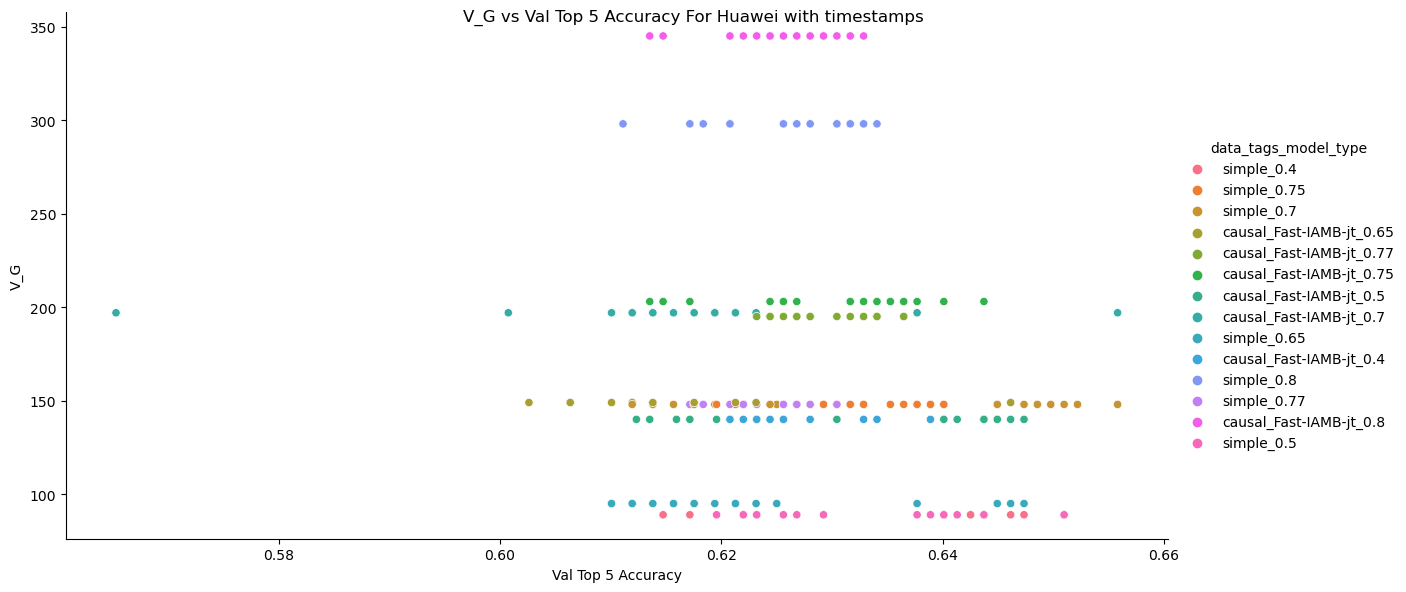

In [127]:
# Plot of all data points => No clear trend to see when looking at total number
# of nodes
g = sns.relplot(data=huawei_ts_final_df, x='val_top_5_categorical_accuracy_history_best', y='V_G', hue='data_tags_model_type', height=6, aspect=2)
g.fig.suptitle('V_G vs Val Top 5 Accuracy For Huawei with timestamps')
g.set_xlabels('Val Top 5 Accuracy')
g

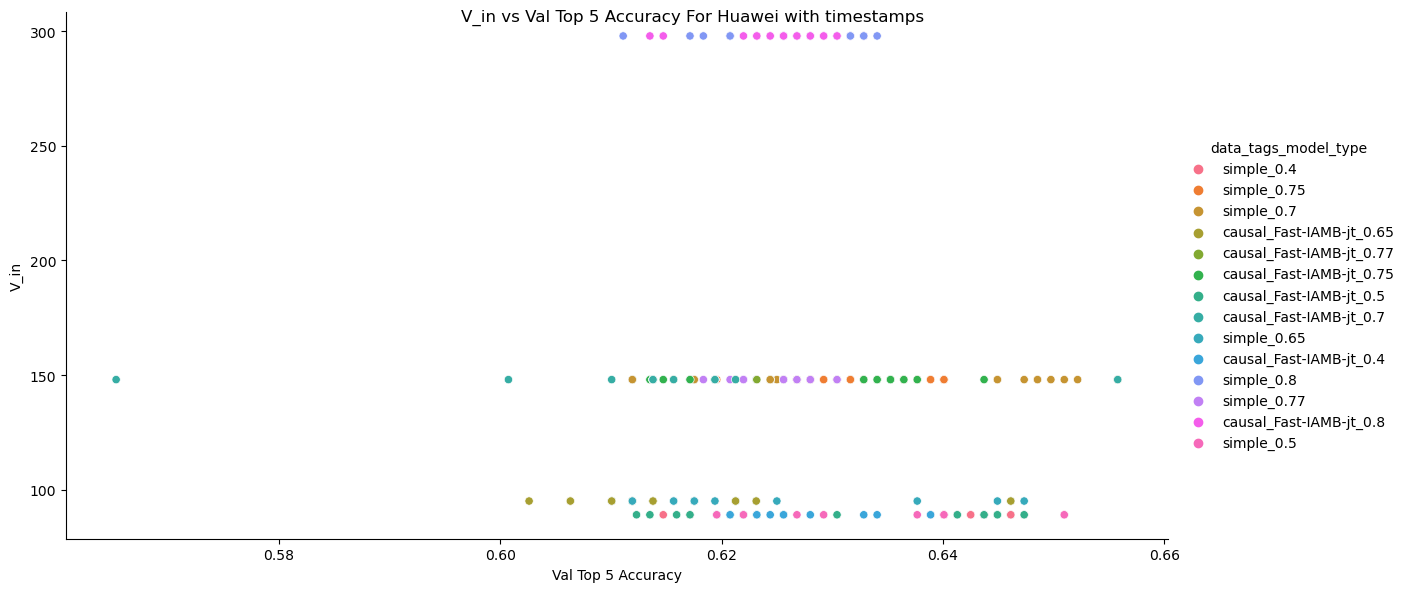

In [128]:
# Plot of all data points => No clear trend to see when looking at input nodes
g = sns.relplot(data=huawei_ts_final_df, x='val_top_5_categorical_accuracy_history_best', y='V_in', hue='data_tags_model_type', height=6, aspect=2)
g.fig.suptitle('V_in vs Val Top 5 Accuracy For Huawei with timestamps')
g.set_xlabels('Val Top 5 Accuracy')
g

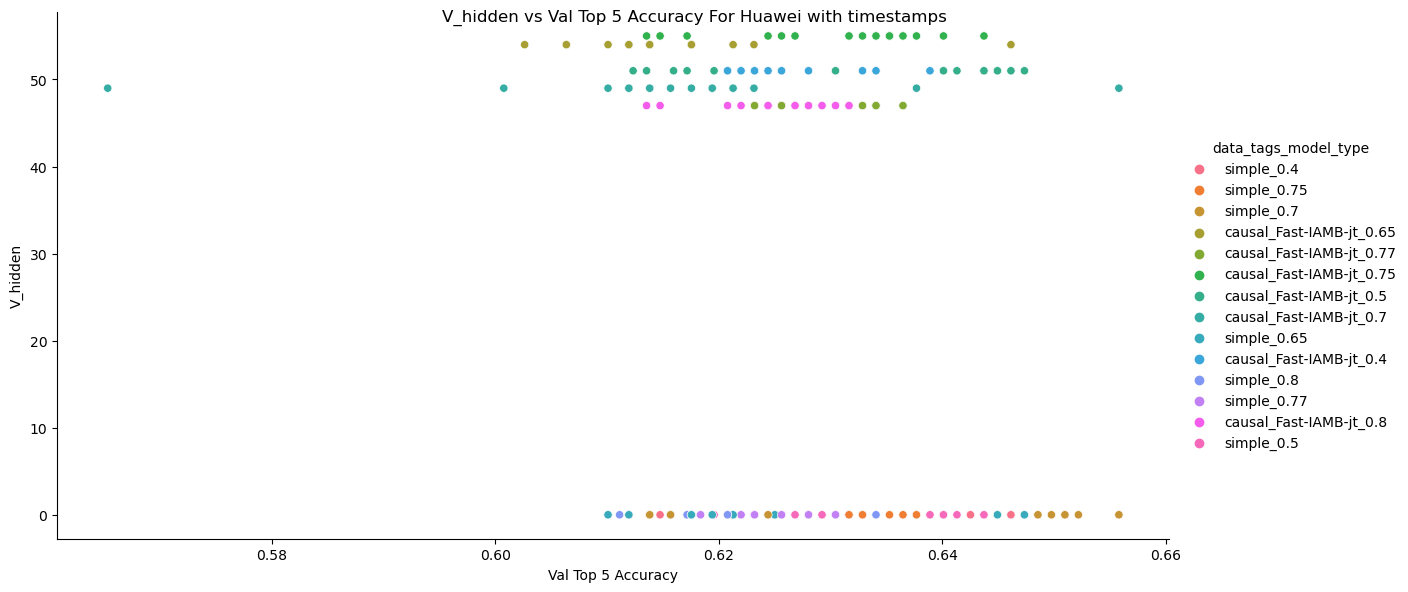

In [129]:
# Plot of all data points => No clear trend to see when looking at hidden nodes
g = sns.relplot(data=huawei_ts_final_df, x='val_top_5_categorical_accuracy_history_best', y='V_hidden', hue='data_tags_model_type', height=6, aspect=2)
g.fig.suptitle('V_hidden vs Val Top 5 Accuracy For Huawei with timestamps')
g.set_xlabels('Val Top 5 Accuracy')
g

#### Simple vs Causal regardless of Drain

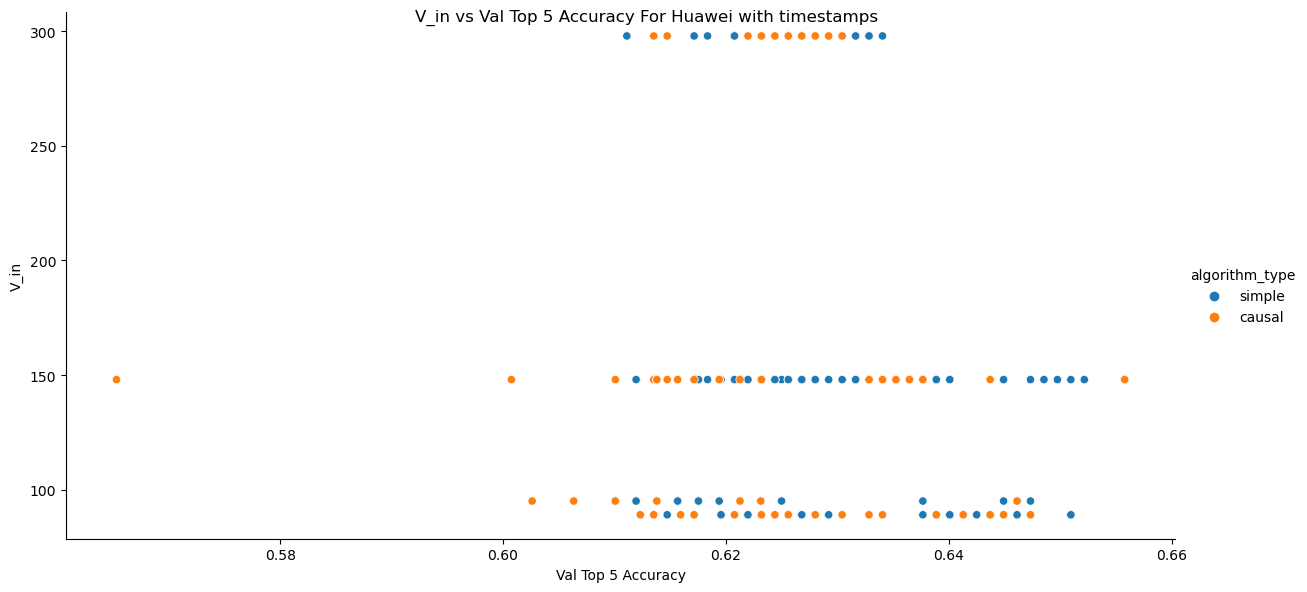

In [130]:
simple_causal_df = huawei_ts_final_df.copy()
simple_causal_df['algorithm_type'] = simple_causal_df['data_tags_model_type'].apply(lambda x: x.split('_')[0])
g = sns.relplot(data=simple_causal_df, x='val_top_5_categorical_accuracy_history_best', y='V_in', hue='algorithm_type', height=6, aspect=2)
g.fig.suptitle('V_in vs Val Top 5 Accuracy For Huawei with timestamps')
g.set_xlabels('Val Top 5 Accuracy')
g

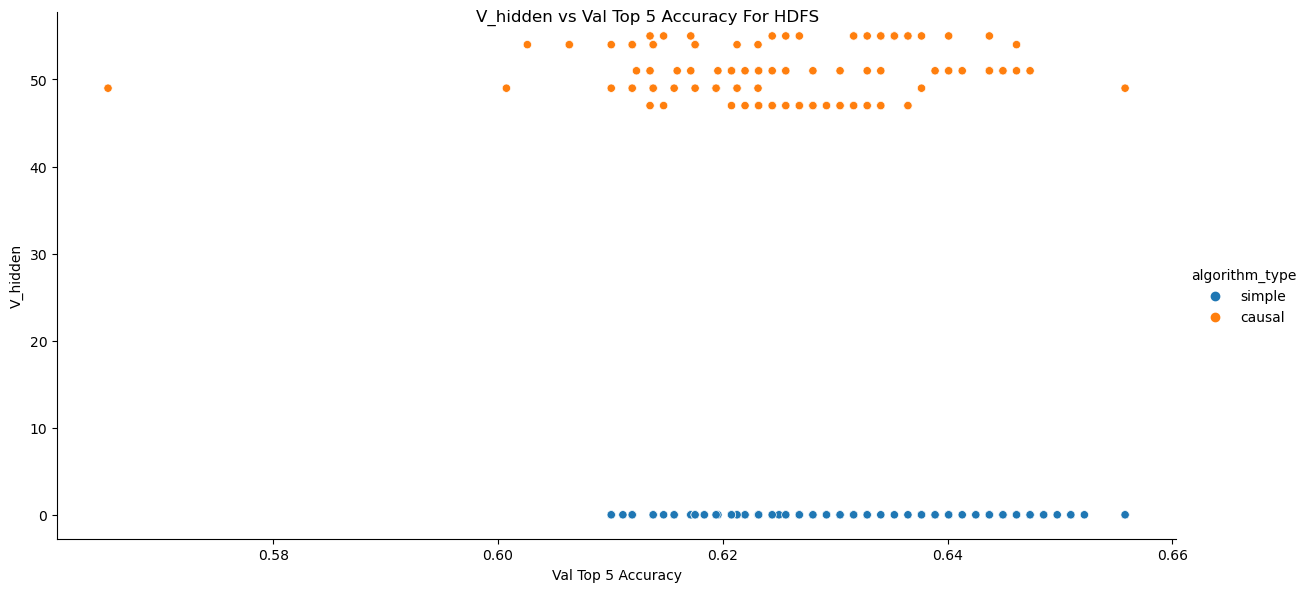

In [131]:
g = sns.relplot(data=simple_causal_df, x='val_top_5_categorical_accuracy_history_best', y='V_hidden', hue='algorithm_type', height=6, aspect=2)
g.fig.suptitle('V_hidden vs Val Top 5 Accuracy For HDFS')
g.set_xlabels('Val Top 5 Accuracy')
g

#### Simple vs other simples 

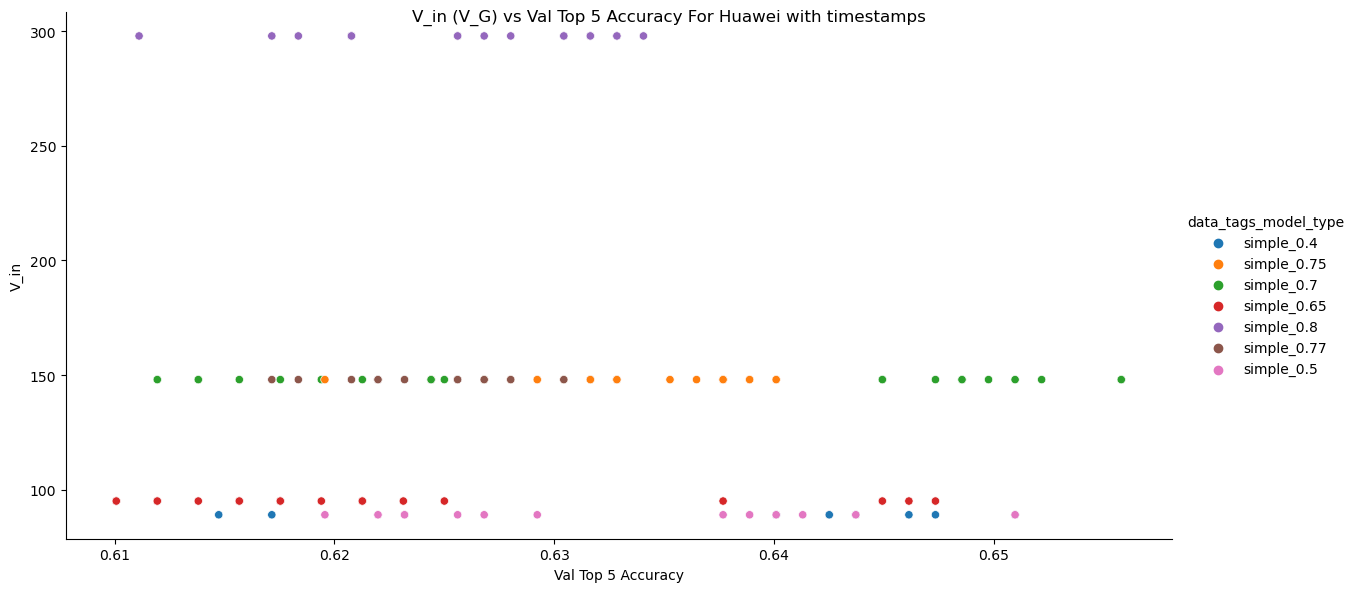

In [132]:
# Note that for simple V_G = V_in
simple_hdfs = huawei_ts_final_df[huawei_ts_final_df['data_tags_model_type'].str.startswith('simple')]
g = sns.relplot(data=simple_hdfs, x='val_top_5_categorical_accuracy_history_best', y='V_in', hue='data_tags_model_type', height=6, aspect=2)
g.fig.suptitle('V_in (V_G) vs Val Top 5 Accuracy For Huawei with timestamps')
g.set_xlabels('Val Top 5 Accuracy')
g

#### Causal vs other causal

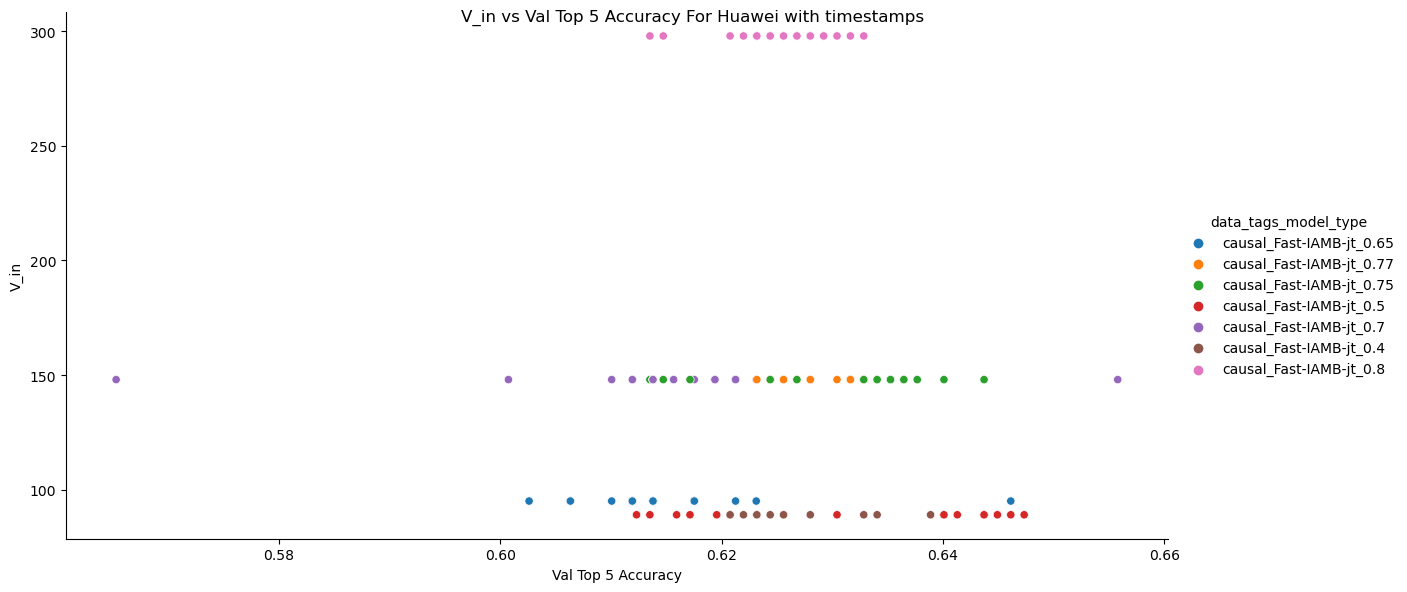

In [133]:
causal_hdfs = huawei_ts_final_df[huawei_ts_final_df['data_tags_model_type'].str.startswith('causal')]
g = sns.relplot(data=causal_hdfs, x='val_top_5_categorical_accuracy_history_best', y='V_in', hue='data_tags_model_type', height=6, aspect=2)
g.fig.suptitle('V_in vs Val Top 5 Accuracy For Huawei with timestamps')
g.set_xlabels('Val Top 5 Accuracy')
g

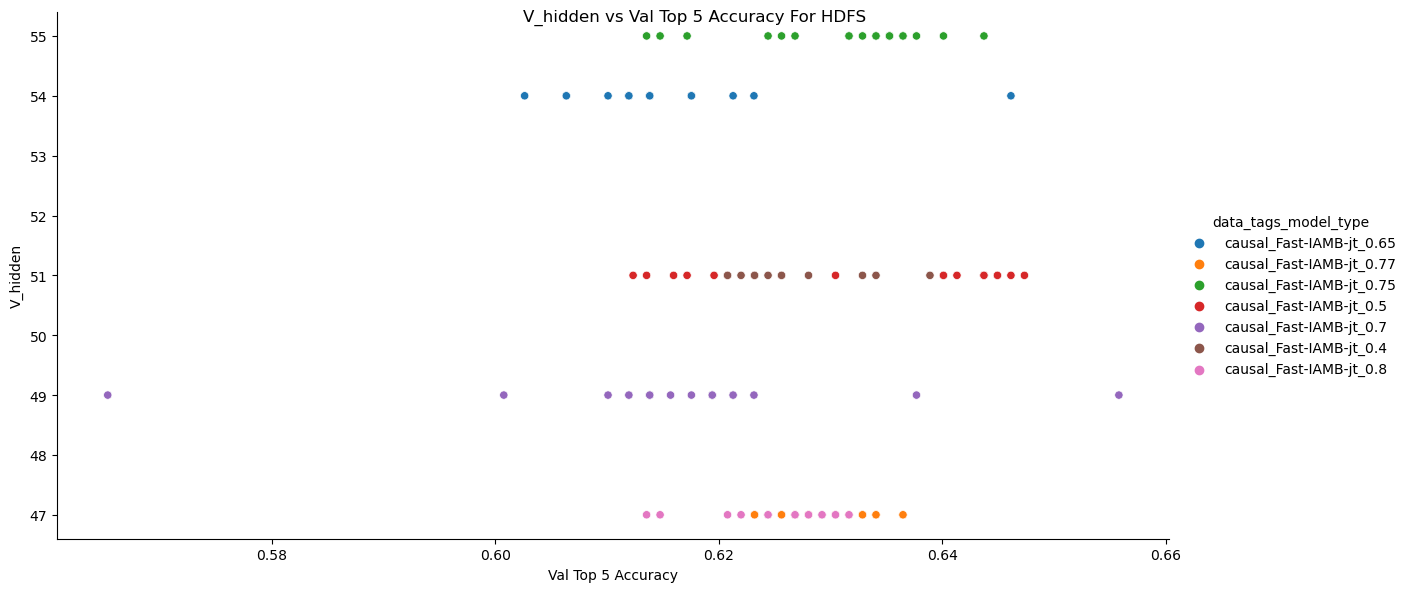

In [134]:
causal_hdfs = huawei_ts_final_df[huawei_ts_final_df['data_tags_model_type'].str.startswith('causal')]
g = sns.relplot(data=causal_hdfs, x='val_top_5_categorical_accuracy_history_best', y='V_hidden', hue='data_tags_model_type', height=6, aspect=2)
g.fig.suptitle('V_hidden vs Val Top 5 Accuracy For HDFS')
g.set_xlabels('Val Top 5 Accuracy')
g

#### Compare on basis of drain settings

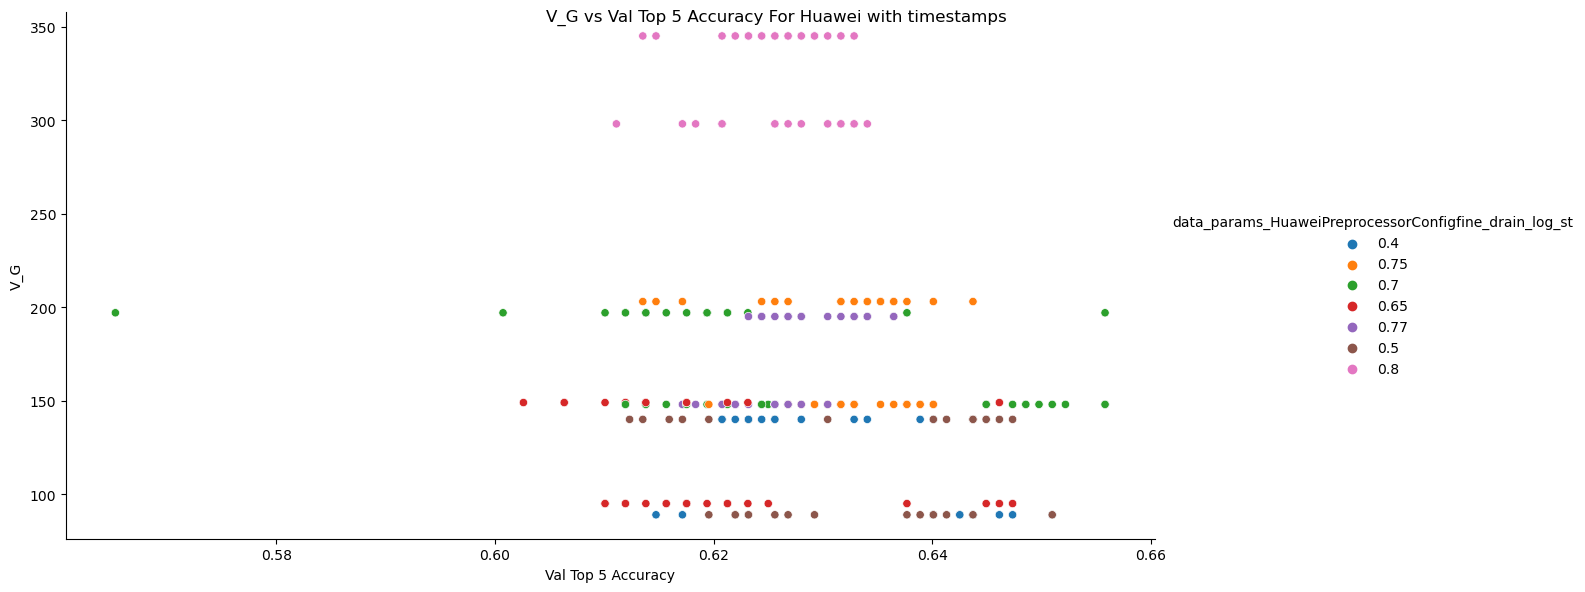

In [135]:
g = sns.relplot(data=huawei_ts_final_df, x='val_top_5_categorical_accuracy_history_best', y='V_G', hue='data_params_HuaweiPreprocessorConfigfine_drain_log_st', height=6, aspect=2)
g.fig.suptitle('V_G vs Val Top 5 Accuracy For Huawei with timestamps')
g.set_xlabels('Val Top 5 Accuracy')
g

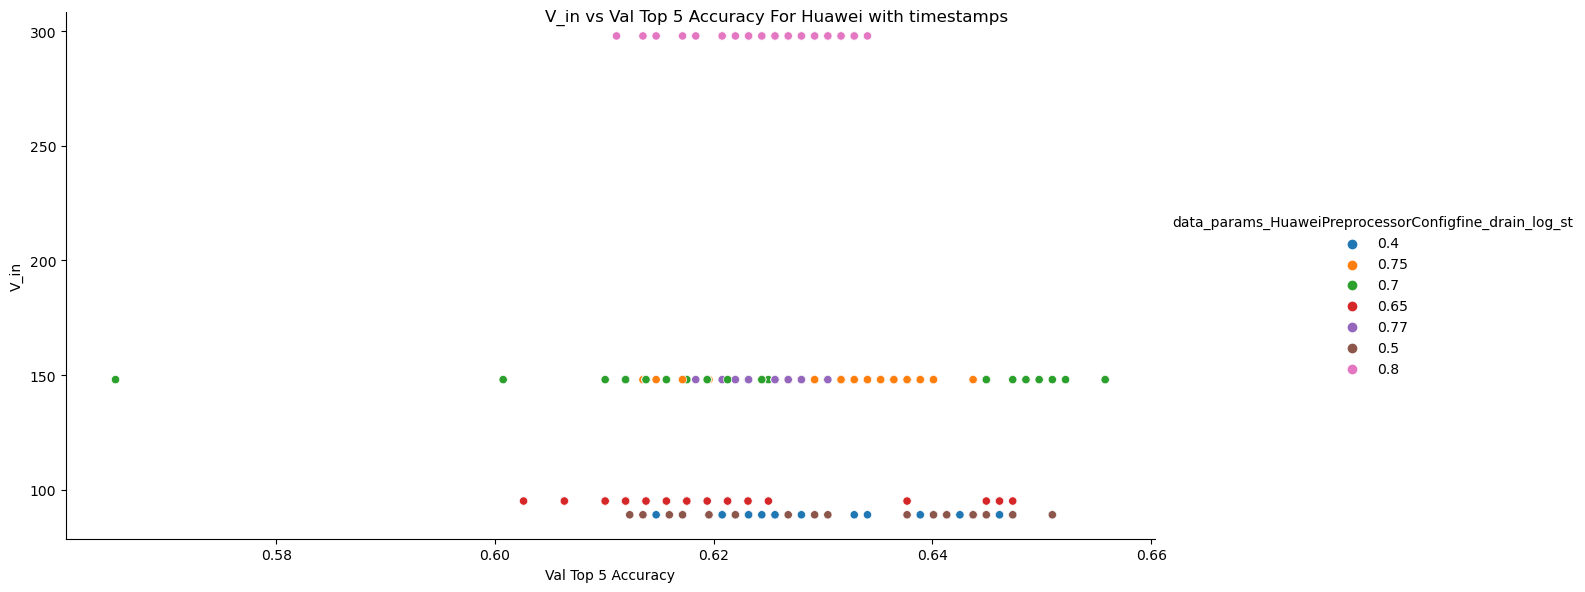

In [136]:
g = sns.relplot(data=huawei_ts_final_df, x='val_top_5_categorical_accuracy_history_best', y='V_in', hue='data_params_HuaweiPreprocessorConfigfine_drain_log_st', height=6, aspect=2)
g.fig.suptitle('V_in vs Val Top 5 Accuracy For Huawei with timestamps')
g.set_xlabels('Val Top 5 Accuracy')
g

### Huawei Without Timestamps

#### Full data

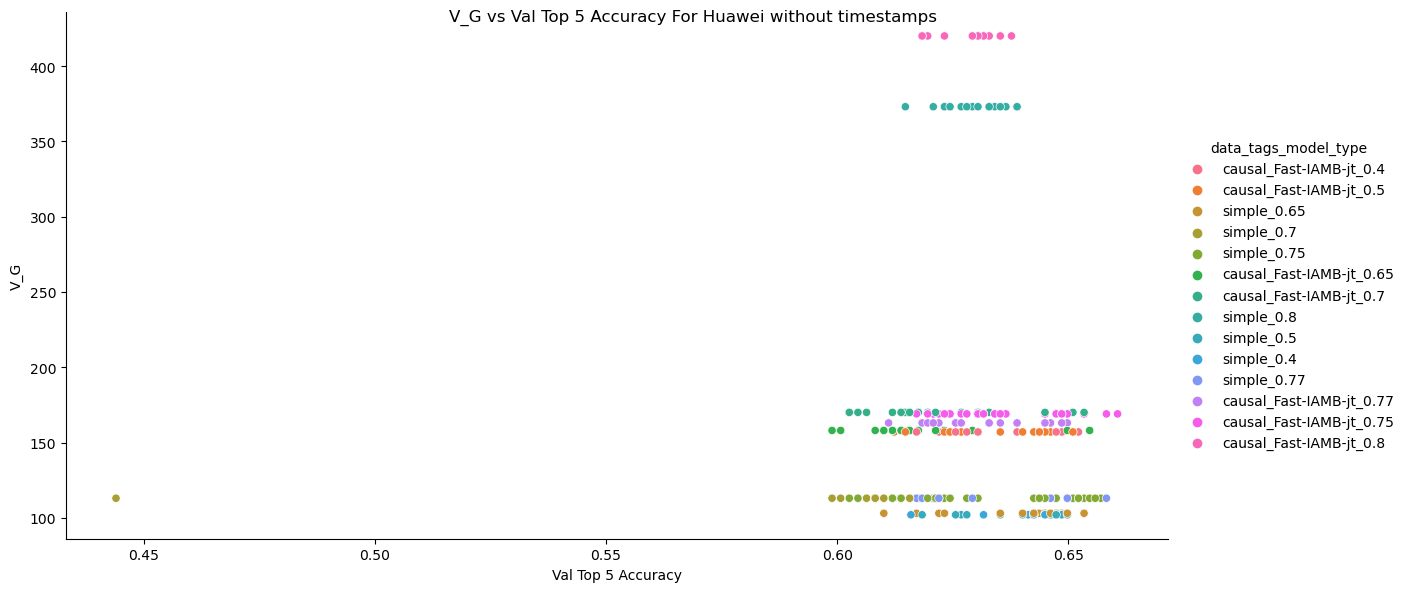

In [137]:
# Plot of all data points => No clear trend to see when looking at total number
# of nodes
g = sns.relplot(data=huawei_no_ts_final_df, x='val_top_5_categorical_accuracy_history_best', y='V_G', hue='data_tags_model_type', height=6, aspect=2)
g.fig.suptitle('V_G vs Val Top 5 Accuracy For Huawei without timestamps')
g.set_xlabels('Val Top 5 Accuracy')
g

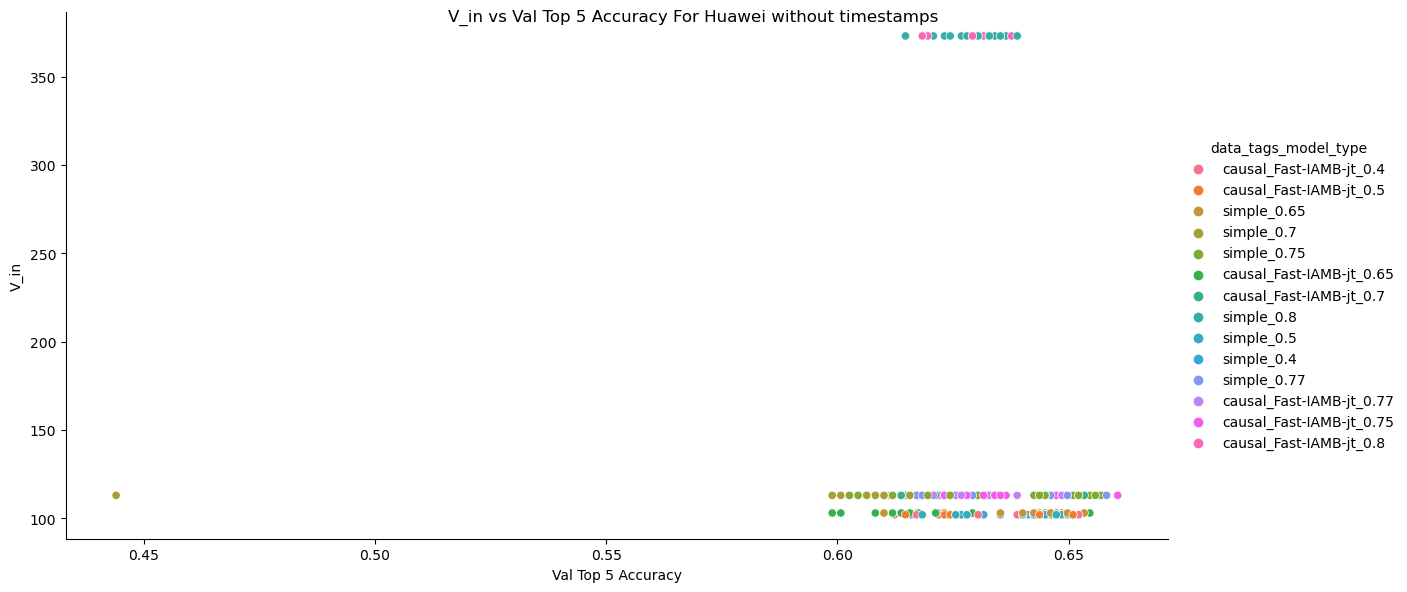

In [138]:
# Plot of all data points => No clear trend to see when looking at input nodes
g = sns.relplot(data=huawei_no_ts_final_df, x='val_top_5_categorical_accuracy_history_best', y='V_in', hue='data_tags_model_type', height=6, aspect=2)
g.fig.suptitle('V_in vs Val Top 5 Accuracy For Huawei without timestamps')
g.set_xlabels('Val Top 5 Accuracy')
g

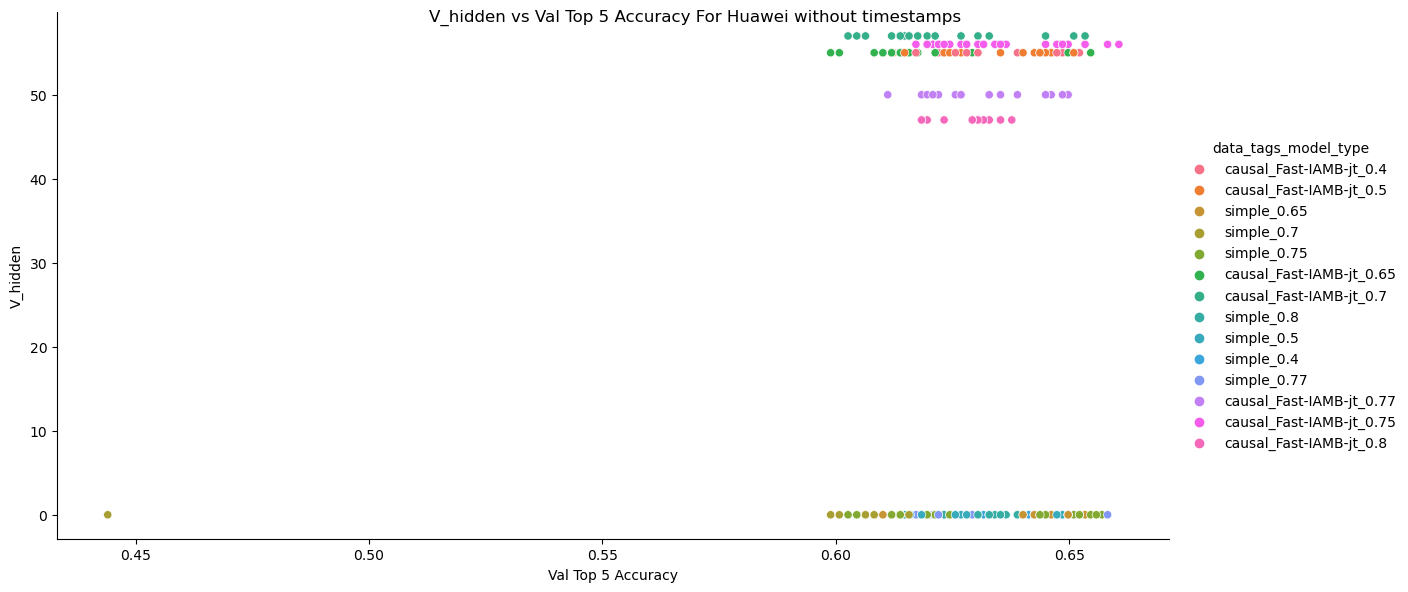

In [139]:
# Plot of all data points => No clear trend to see when looking at hidden nodes
g = sns.relplot(data=huawei_no_ts_final_df, x='val_top_5_categorical_accuracy_history_best', y='V_hidden', hue='data_tags_model_type', height=6, aspect=2)
g.fig.suptitle('V_hidden vs Val Top 5 Accuracy For Huawei without timestamps')
g.set_xlabels('Val Top 5 Accuracy')
g

#### Simple vs Causal regardless of Drain

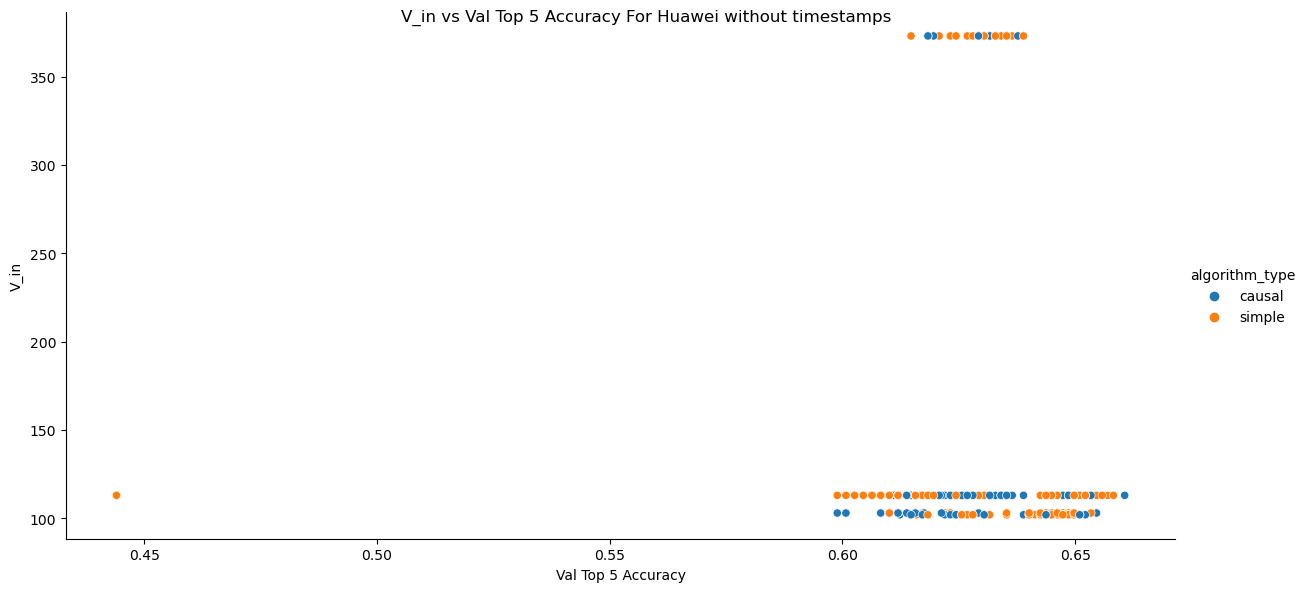

In [140]:
simple_causal_df = huawei_no_ts_final_df.copy()
simple_causal_df['algorithm_type'] = simple_causal_df['data_tags_model_type'].apply(lambda x: x.split('_')[0])
g = sns.relplot(data=simple_causal_df, x='val_top_5_categorical_accuracy_history_best', y='V_in', hue='algorithm_type', height=6, aspect=2)
g.fig.suptitle('V_in vs Val Top 5 Accuracy For Huawei without timestamps')
g.set_xlabels('Val Top 5 Accuracy')
g

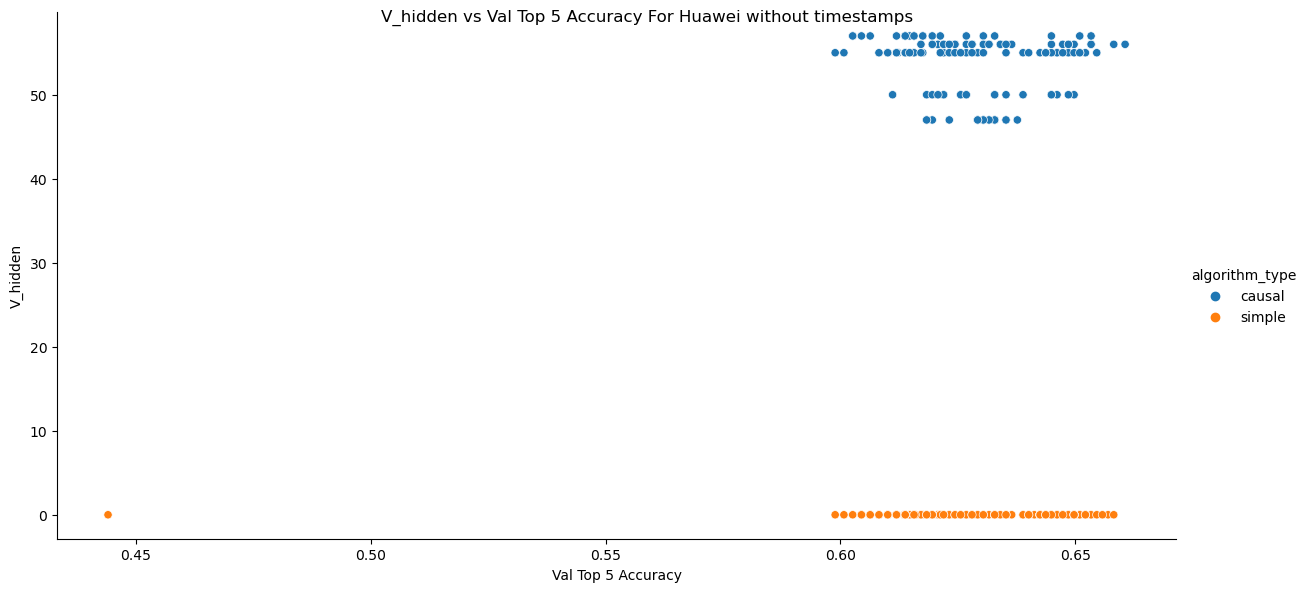

In [141]:
g = sns.relplot(data=simple_causal_df, x='val_top_5_categorical_accuracy_history_best', y='V_hidden', hue='algorithm_type', height=6, aspect=2)
g.fig.suptitle('V_hidden vs Val Top 5 Accuracy For Huawei without timestamps')
g.set_xlabels('Val Top 5 Accuracy')
g

#### Simple vs other simples 

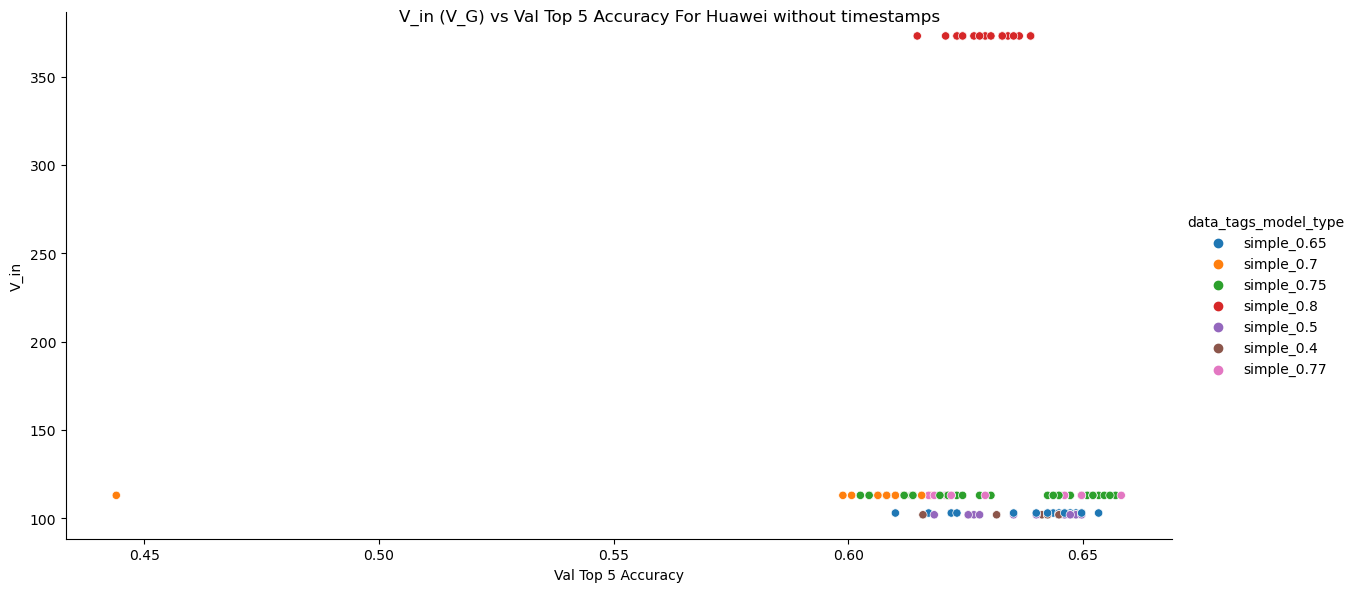

In [142]:
# Note that for simple V_G = V_in
simple_hdfs = huawei_no_ts_final_df[huawei_no_ts_final_df['data_tags_model_type'].str.startswith('simple')]
g = sns.relplot(data=simple_hdfs, x='val_top_5_categorical_accuracy_history_best', y='V_in', hue='data_tags_model_type', height=6, aspect=2)
g.fig.suptitle('V_in (V_G) vs Val Top 5 Accuracy For Huawei without timestamps')
g.set_xlabels('Val Top 5 Accuracy')
g

#### Causal vs other causal

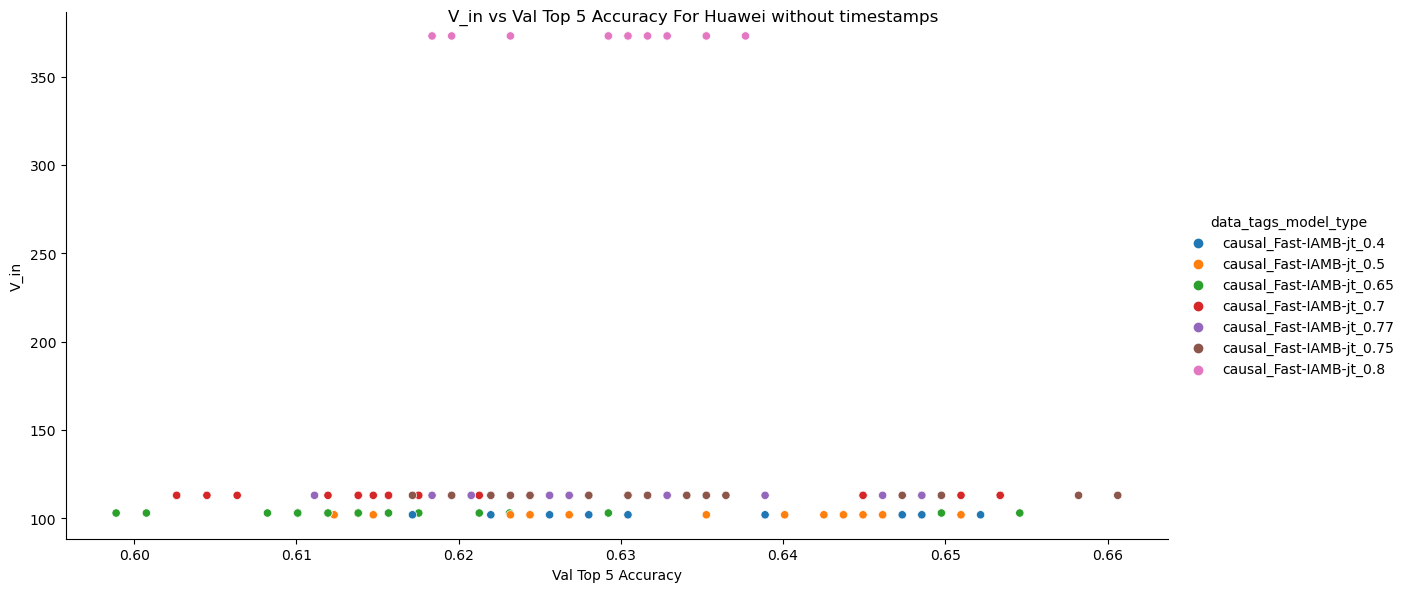

In [143]:
causal_hdfs = huawei_no_ts_final_df[huawei_no_ts_final_df['data_tags_model_type'].str.startswith('causal')]
g = sns.relplot(data=causal_hdfs, x='val_top_5_categorical_accuracy_history_best', y='V_in', hue='data_tags_model_type', height=6, aspect=2)
g.fig.suptitle('V_in vs Val Top 5 Accuracy For Huawei without timestamps')
g.set_xlabels('Val Top 5 Accuracy')
g

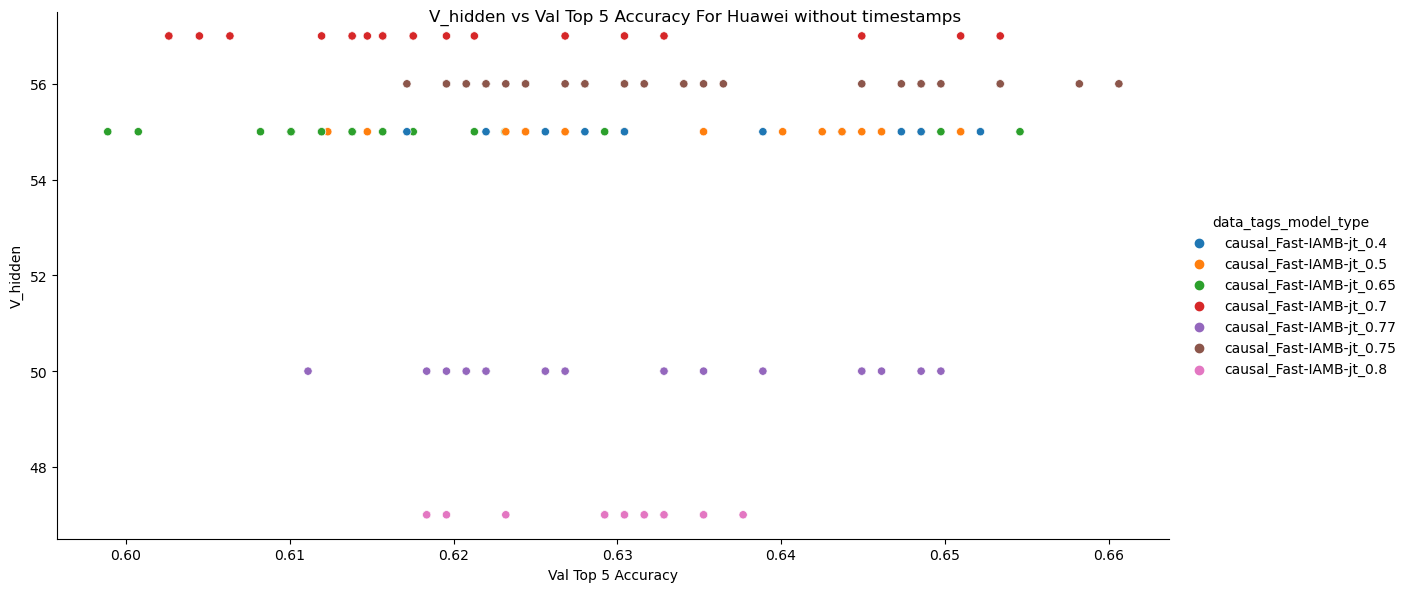

In [144]:
causal_hdfs = huawei_no_ts_final_df[huawei_no_ts_final_df['data_tags_model_type'].str.startswith('causal')]
g = sns.relplot(data=causal_hdfs, x='val_top_5_categorical_accuracy_history_best', y='V_hidden', hue='data_tags_model_type', height=6, aspect=2)
g.fig.suptitle('V_hidden vs Val Top 5 Accuracy For Huawei without timestamps')
g.set_xlabels('Val Top 5 Accuracy')
g

#### Compare on basis of drain settings

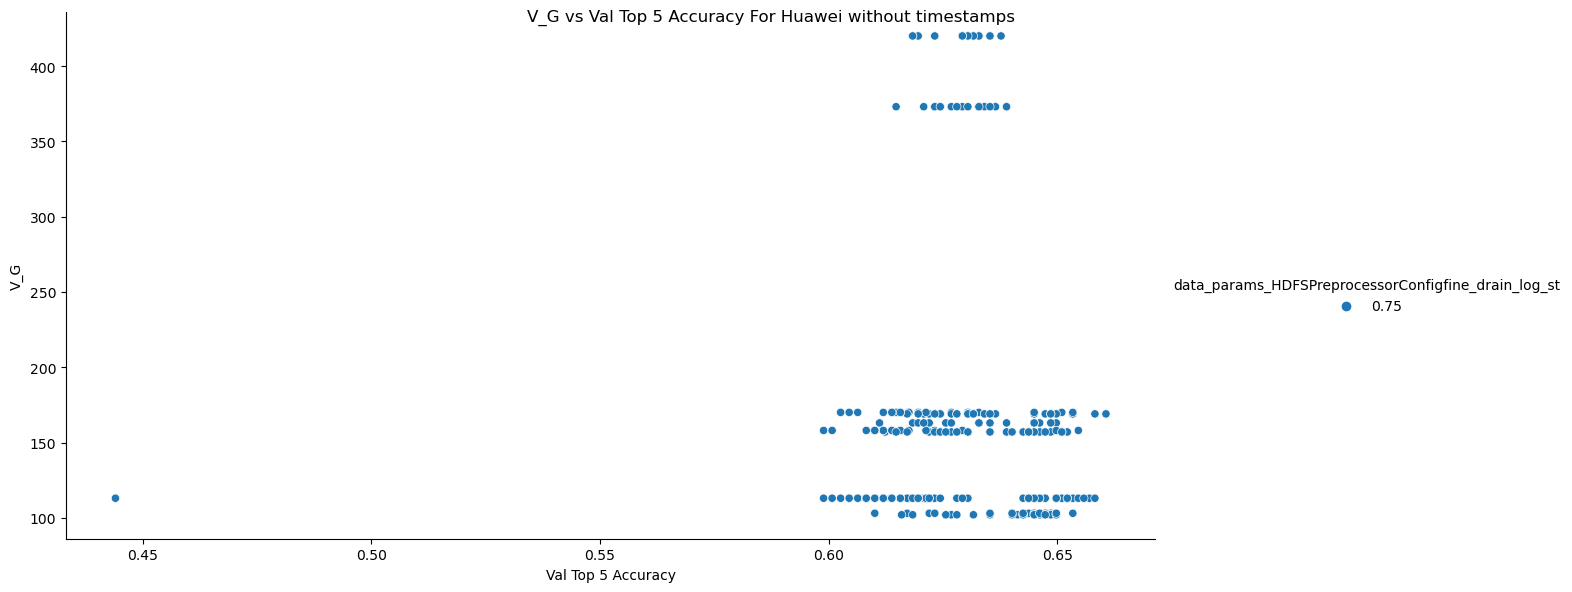

In [145]:
g = sns.relplot(data=huawei_no_ts_final_df, x='val_top_5_categorical_accuracy_history_best', y='V_G', hue='data_params_HDFSPreprocessorConfigfine_drain_log_st', height=6, aspect=2)
g.fig.suptitle('V_G vs Val Top 5 Accuracy For Huawei without timestamps')
g.set_xlabels('Val Top 5 Accuracy')
g

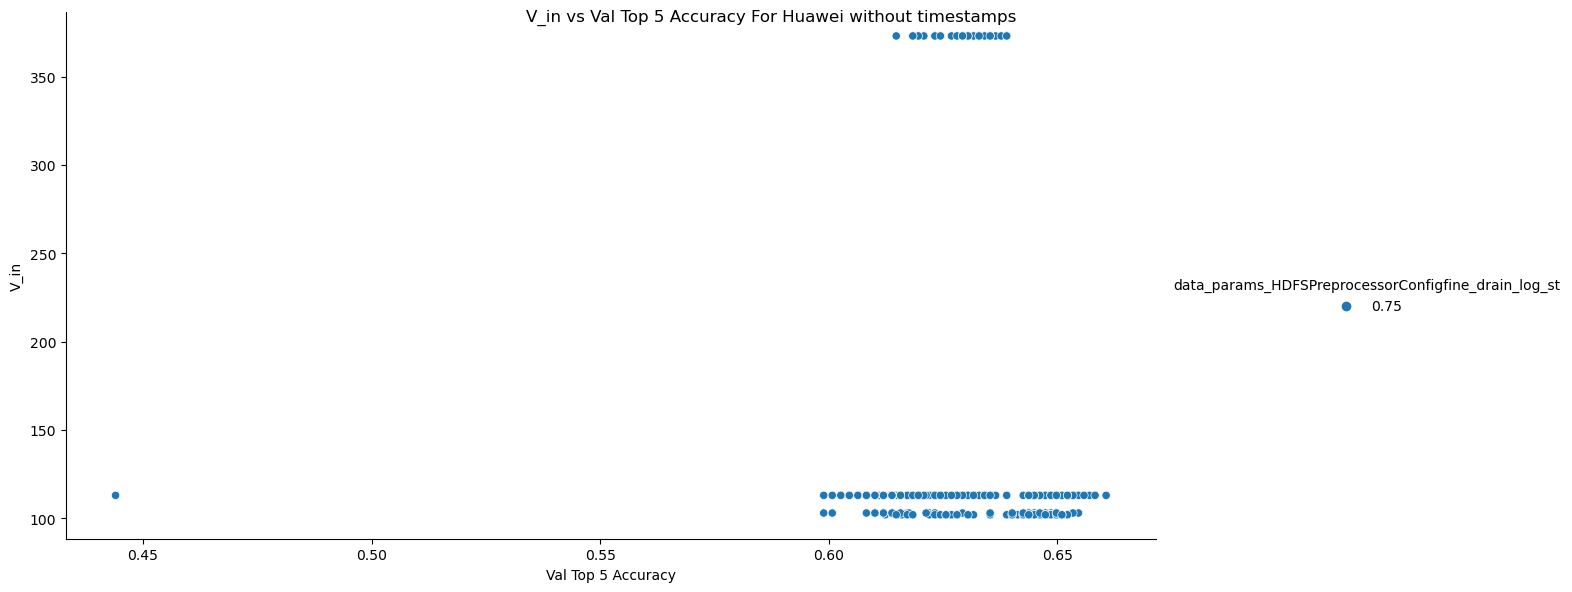

In [146]:
g = sns.relplot(data=huawei_no_ts_final_df, x='val_top_5_categorical_accuracy_history_best', y='V_in', hue='data_params_HDFSPreprocessorConfigfine_drain_log_st', height=6, aspect=2)
g.fig.suptitle('V_in vs Val Top 5 Accuracy For Huawei without timestamps')
g.set_xlabels('Val Top 5 Accuracy')
g

### BGL

In [84]:
bgl_df = mlflow_helper.run_df[
    (mlflow_helper.run_df['data_tags_sequence_type'] == 'bgl_logs')
    & (mlflow_helper.run_df['data_tags_model_type'].isin(['simple', 'causal_Fast-IAMB-jt']))
    & (mlflow_helper.run_df['data_params_BGLPreprocessorConfigaggregated_log_file'] == 'data/2k/bgl/BGL_2k.csv')
    & (mlflow_helper.run_df["info_status"] == "FINISHED")
    & (mlflow_helper.run_df["data_params_BGLPreprocessorConfigfine_drain_log_st"].astype(str).fillna("").isin(check))
    & (mlflow_helper.run_df['data_params_ExperimentConfigonly_generate_knowledge'] == 'False')
]
bgl_df = mlflow_helper.load_best_metrics_for_ids(set(bgl_df["info_run_id"]))

Querying metrics for runs: 100%|██████████| 318/318 [00:19<00:00, 16.37it/s]


In [85]:
bgl_df = classify_sp_df(bgl_df, check, dataset='BGL')
bgl_df.groupby(['data_tags_model_type']).size()

data_tags_model_type
causal_Fast-IAMB-jt_0.4     10
causal_Fast-IAMB-jt_0.5     20
causal_Fast-IAMB-jt_0.65    26
causal_Fast-IAMB-jt_0.7     20
causal_Fast-IAMB-jt_0.75    20
causal_Fast-IAMB-jt_0.77    20
causal_Fast-IAMB-jt_0.8     20
simple_0.4                  10
simple_0.5                  20
simple_0.65                 72
simple_0.7                  20
simple_0.75                 20
simple_0.77                 20
simple_0.8                  20
dtype: int64

In [88]:
bgl_stats_df = fetch_statistics('causal_Fast-IAMB-jt', check, dataset='bgl')
bgl_stats_df

Building Causality from df: 94it [00:00, 33798.93it/s]
Building Causality from df: 94it [00:00, 39608.66it/s]
Building Causality from df: 94it [00:00, 40006.55it/s]
Building Causality from df: 94it [00:00, 40022.80it/s]
Building Causality from df: 94it [00:00, 41898.47it/s]
Building Causality from df: 94it [00:00, 42086.31it/s]
Building Causality from df: 94it [00:00, 41624.22it/s]


,Model,V_G,V_in,V_hidden,E_G
0,causal_Fast-IAMB-jt_0.77_st,2,1,1,1
1,causal_Fast-IAMB-jt_0.8_st,2009,2000,9,2011
2,causal_Fast-IAMB-jt_0.75_st,2,1,1,2
3,causal_Fast-IAMB-jt_0.65_st,2,1,1,2
4,causal_Fast-IAMB-jt_0.7_st,2,1,1,2
5,causal_Fast-IAMB-jt_0.4_st,2,1,1,2
6,causal_Fast-IAMB-jt_0.5_st,2,1,1,2


In [89]:
# Add simple
to_append = []
for x in bgl_stats_df['Model'].tolist():
    s = x.split('_')[2]
    name = f'simple_{s}'
    v_in = bgl_stats_df[bgl_stats_df['Model'] == x]['V_in'].tolist()[0]
    to_append.append({
        'Model': name,
        'V_G': v_in,
        'V_in': v_in,
        'V_hidden': 0,
        'E_G': 0
    })
bgl_stats_df = pd.concat([bgl_stats_df, pd.DataFrame.from_records(to_append)]).reset_index(drop=True)
bgl_stats_df

,Model,V_G,V_in,V_hidden,E_G
0,causal_Fast-IAMB-jt_0.77_st,2,1,1,1
1,causal_Fast-IAMB-jt_0.8_st,2009,2000,9,2011
2,causal_Fast-IAMB-jt_0.75_st,2,1,1,2
3,causal_Fast-IAMB-jt_0.65_st,2,1,1,2
4,causal_Fast-IAMB-jt_0.7_st,2,1,1,2
5,causal_Fast-IAMB-jt_0.4_st,2,1,1,2
6,causal_Fast-IAMB-jt_0.5_st,2,1,1,2
7,simple_0.77,1,1,0,0
8,simple_0.8,2000,2000,0,0
9,simple_0.75,1,1,0,0


In [90]:
bgl_final_df = pd.merge(bgl_df, bgl_stats_df, how='left', left_on='data_tags_model_type', right_on='Model')

In [91]:
bgl_final_df.groupby(['data_tags_model_type']).size()

data_tags_model_type
causal_Fast-IAMB-jt_0.4     10
causal_Fast-IAMB-jt_0.5     20
causal_Fast-IAMB-jt_0.65    26
causal_Fast-IAMB-jt_0.7     20
causal_Fast-IAMB-jt_0.75    20
causal_Fast-IAMB-jt_0.77    20
causal_Fast-IAMB-jt_0.8     20
simple_0.4                  10
simple_0.5                  20
simple_0.65                 72
simple_0.7                  20
simple_0.75                 20
simple_0.77                 20
simple_0.8                  20
dtype: int64

### HDFS

In [92]:
hdfs_df = mlflow_helper.run_df[
    (mlflow_helper.run_df['data_tags_sequence_type'] == 'hdfs_logs')
    & (mlflow_helper.run_df['data_tags_model_type'].isin(['simple', 'causal_Fast-IAMB-jt']))
    & (mlflow_helper.run_df['data_params_HDFSPreprocessorConfigaggregated_log_file'] == 'data/2k/hdfs/HDFS_2k.csv')
    & (mlflow_helper.run_df["info_status"] == "FINISHED")
    & (mlflow_helper.run_df["data_params_HDFSPreprocessorConfigfine_drain_log_st"].astype(str).fillna("").isin(check))
    & (mlflow_helper.run_df['data_params_ExperimentConfigonly_generate_knowledge'] == 'False')
]
hdfs_df = mlflow_helper.load_best_metrics_for_ids(set(hdfs_df["info_run_id"]))

Querying metrics for runs: 100%|██████████| 296/296 [00:18<00:00, 16.40it/s]


In [93]:
hdfs_df = classify_sp_df(hdfs_df, check, dataset='HDFS')
hdfs_df.groupby(['data_tags_model_type']).size()

data_tags_model_type
causal_Fast-IAMB-jt_0.4     10
causal_Fast-IAMB-jt_0.5     20
causal_Fast-IAMB-jt_0.65    20
causal_Fast-IAMB-jt_0.7     18
causal_Fast-IAMB-jt_0.75    41
causal_Fast-IAMB-jt_0.77    20
causal_Fast-IAMB-jt_0.8     20
simple_0.4                  10
simple_0.5                  20
simple_0.65                 22
simple_0.7                  20
simple_0.75                 35
simple_0.77                 20
simple_0.8                  20
dtype: int64

In [103]:
hdfs_stats_df = fetch_statistics('causal_Fast-IAMB-jt', check, dataset='hdfs')
# Remove modifiers
hdfs_stats_df['Model'] = hdfs_stats_df['Model'].apply(lambda x: x.replace('_st', ''))

Building Causality from df: 30it [00:00, 34654.12it/s]
Building Causality from df: 30it [00:00, 34894.38it/s]
Building Causality from df: 30it [00:00, 35899.89it/s]
Building Causality from df: 30it [00:00, 35595.22it/s]
Building Causality from df: 30it [00:00, 34568.44it/s]
Building Causality from df: 30it [00:00, 37382.39it/s]
Building Causality from df: 30it [00:00, 36209.82it/s]


In [104]:
# Add simple
to_append = []
for x in hdfs_stats_df['Model'].tolist():
    s = x.split('_')[2]
    name = f'simple_{s}'
    v_in = hdfs_stats_df[hdfs_stats_df['Model'] == x]['V_in'].tolist()[0]
    to_append.append({
        'Model': name,
        'V_G': v_in,
        'V_in': v_in,
        'V_hidden': 0,
        'E_G': 0
    })
hdfs_stats_df = pd.concat([hdfs_stats_df, pd.DataFrame.from_records(to_append)]).reset_index(drop=True)
hdfs_stats_df

,Model,V_G,V_in,V_hidden,E_G
0,causal_Fast-IAMB-jt_0.77,161,159,2,165
1,causal_Fast-IAMB-jt_0.8,172,170,2,176
2,causal_Fast-IAMB-jt_0.75,161,159,2,165
3,causal_Fast-IAMB-jt_0.65,159,157,2,163
4,causal_Fast-IAMB-jt_0.7,161,159,2,165
5,causal_Fast-IAMB-jt_0.4,8,7,1,7
6,causal_Fast-IAMB-jt_0.5,8,7,1,7
7,simple_0.77,159,159,0,0
8,simple_0.8,170,170,0,0
9,simple_0.75,159,159,0,0


In [105]:
hdfs_final_df = pd.merge(hdfs_df, hdfs_stats_df, how='left', left_on='data_tags_model_type', right_on='Model')

In [106]:
hdfs_final_df.groupby(['data_tags_model_type']).size()

data_tags_model_type
causal_Fast-IAMB-jt_0.4     10
causal_Fast-IAMB-jt_0.5     20
causal_Fast-IAMB-jt_0.65    20
causal_Fast-IAMB-jt_0.7     18
causal_Fast-IAMB-jt_0.75    41
causal_Fast-IAMB-jt_0.77    20
causal_Fast-IAMB-jt_0.8     20
simple_0.4                  10
simple_0.5                  20
simple_0.65                 22
simple_0.7                  20
simple_0.75                 35
simple_0.77                 20
simple_0.8                  20
dtype: int64

#### Full data

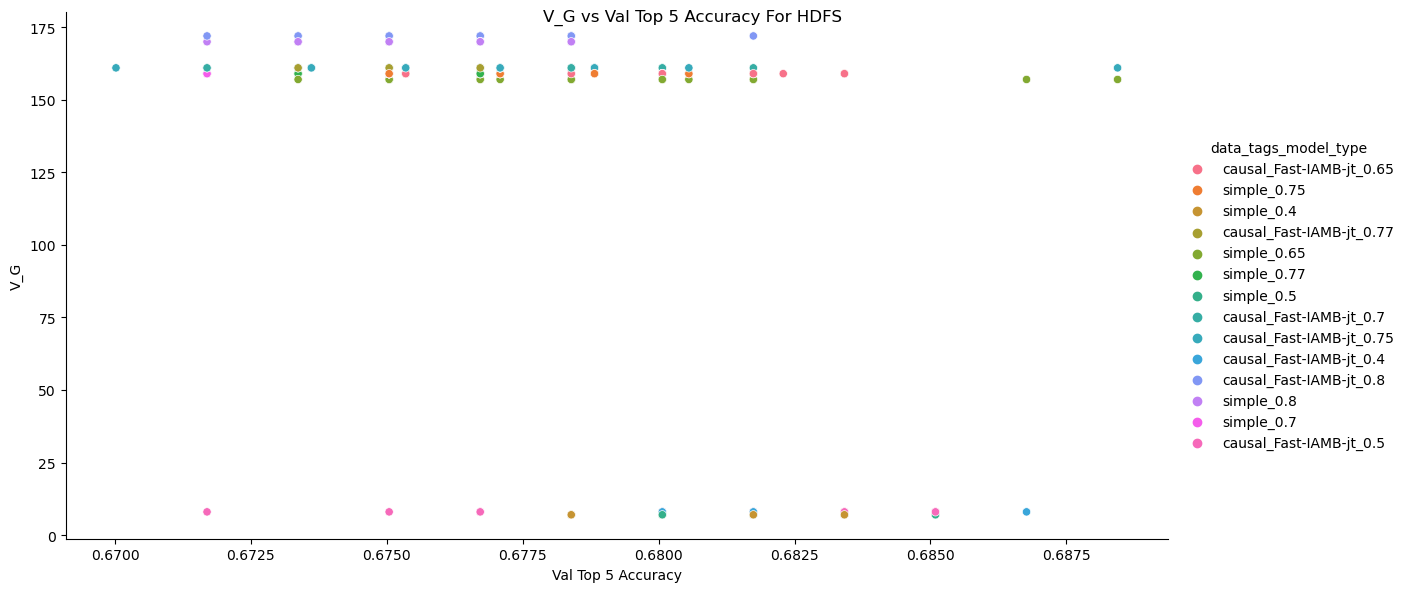

In [107]:
# Plot of all data points => No clear trend to see when looking at total number
# of nodes
g = sns.relplot(data=hdfs_final_df, x='val_top_5_categorical_accuracy_history_best', y='V_G', hue='data_tags_model_type', height=6, aspect=2)
g.fig.suptitle('V_G vs Val Top 5 Accuracy For HDFS')
g.set_xlabels('Val Top 5 Accuracy')
g

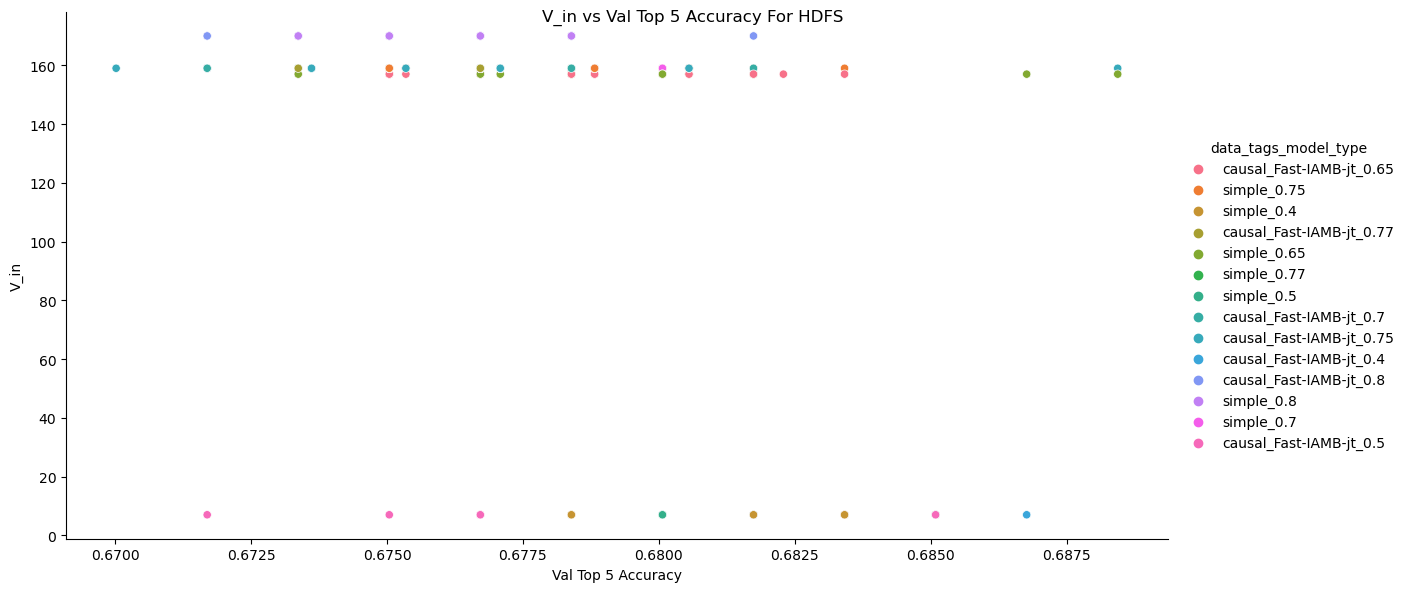

In [108]:
# Plot of all data points => No clear trend to see when looking at input nodes
g = sns.relplot(data=hdfs_final_df, x='val_top_5_categorical_accuracy_history_best', y='V_in', hue='data_tags_model_type', height=6, aspect=2)
g.fig.suptitle('V_in vs Val Top 5 Accuracy For HDFS')
g.set_xlabels('Val Top 5 Accuracy')
g

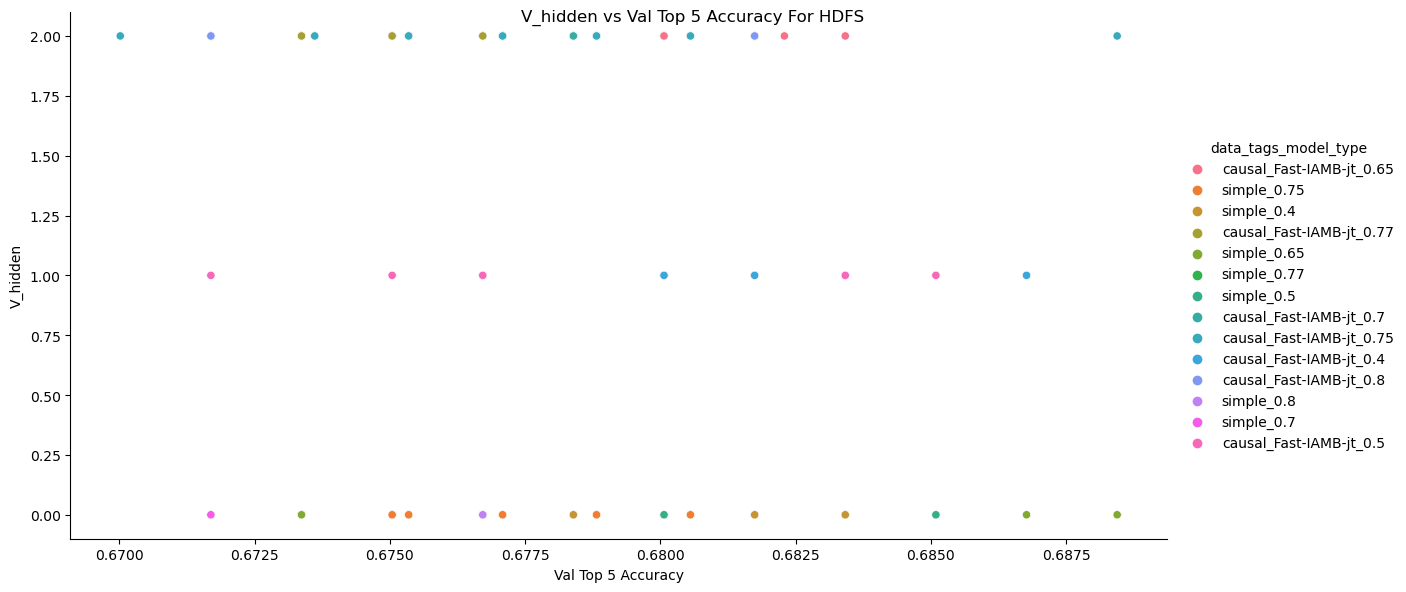

In [109]:
# Plot of all data points => No clear trend to see when looking at hidden nodes
g = sns.relplot(data=hdfs_final_df, x='val_top_5_categorical_accuracy_history_best', y='V_hidden', hue='data_tags_model_type', height=6, aspect=2)
g.fig.suptitle('V_hidden vs Val Top 5 Accuracy For HDFS')
g.set_xlabels('Val Top 5 Accuracy')
g

#### Simple vs Causal regardless of Drain

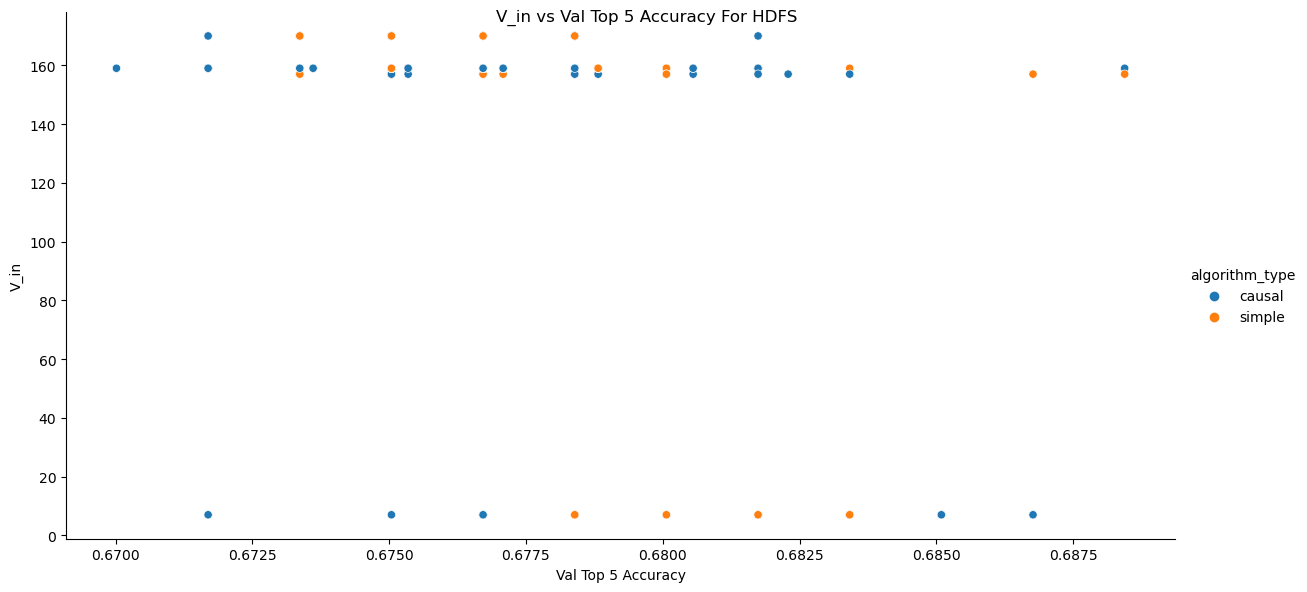

In [110]:
simple_causal_df = hdfs_final_df.copy()
simple_causal_df['algorithm_type'] = simple_causal_df['data_tags_model_type'].apply(lambda x: x.split('_')[0])
g = sns.relplot(data=simple_causal_df, x='val_top_5_categorical_accuracy_history_best', y='V_in', hue='algorithm_type', height=6, aspect=2)
g.fig.suptitle('V_in vs Val Top 5 Accuracy For HDFS')
g.set_xlabels('Val Top 5 Accuracy')
g

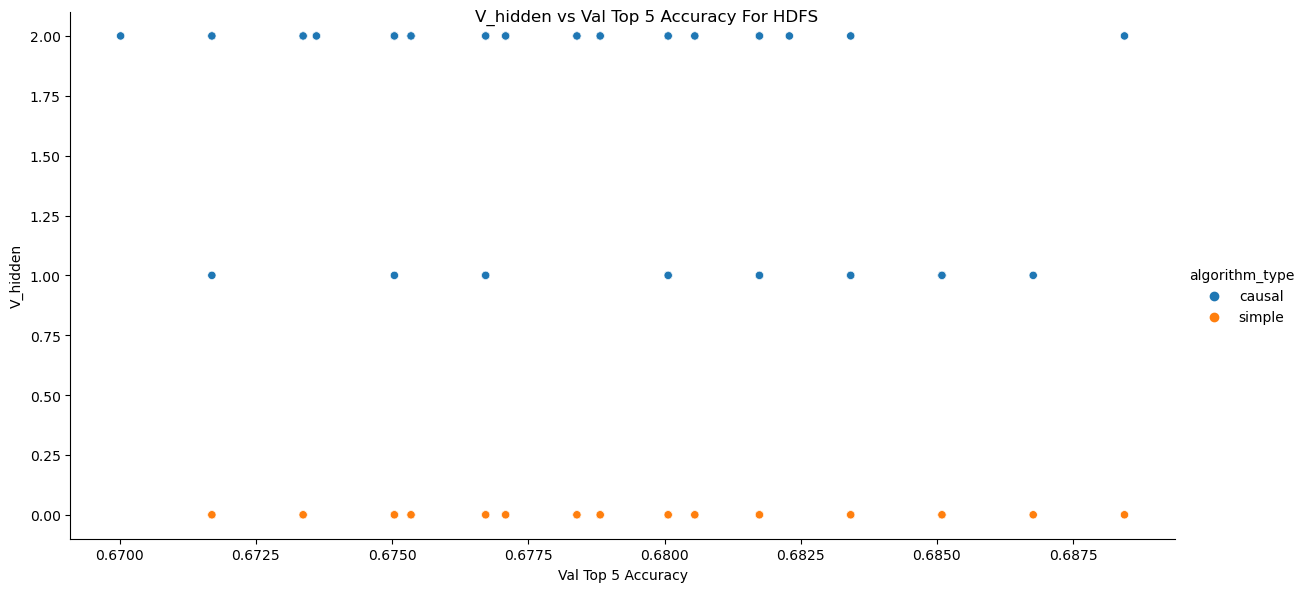

In [111]:
g = sns.relplot(data=simple_causal_df, x='val_top_5_categorical_accuracy_history_best', y='V_hidden', hue='algorithm_type', height=6, aspect=2)
g.fig.suptitle('V_hidden vs Val Top 5 Accuracy For HDFS')
g.set_xlabels('Val Top 5 Accuracy')
g

#### Simple vs other simples 

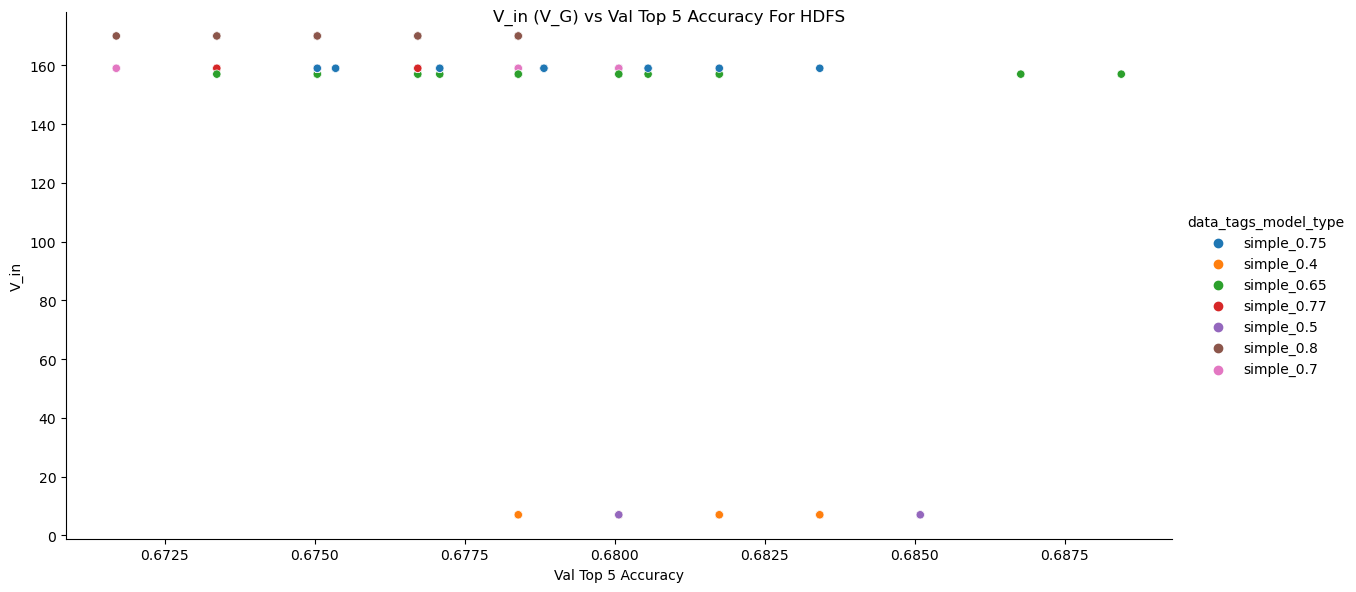

In [112]:
# Note that for simple V_G = V_in
simple_hdfs = hdfs_final_df[hdfs_final_df['data_tags_model_type'].str.startswith('simple')]
g = sns.relplot(data=simple_hdfs, x='val_top_5_categorical_accuracy_history_best', y='V_in', hue='data_tags_model_type', height=6, aspect=2)
g.fig.suptitle('V_in (V_G) vs Val Top 5 Accuracy For HDFS')
g.set_xlabels('Val Top 5 Accuracy')
g

#### Causal vs other causal

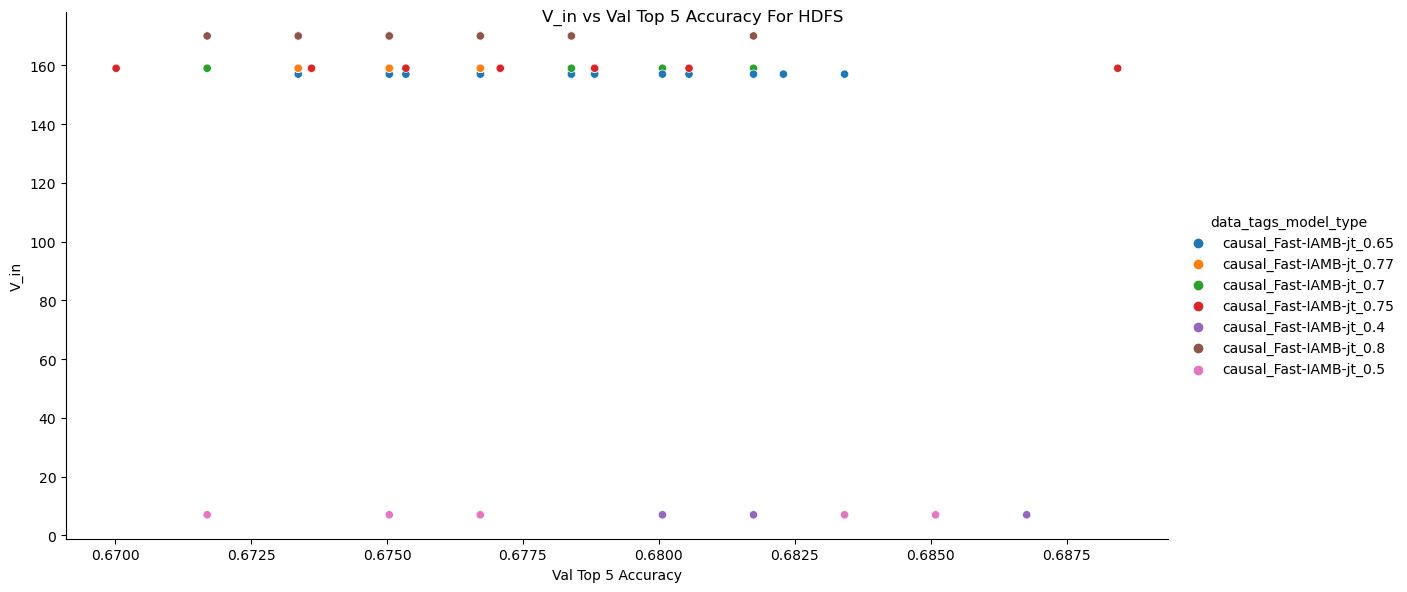

In [124]:
causal_hdfs = hdfs_final_df[hdfs_final_df['data_tags_model_type'].str.startswith('causal')]
g = sns.relplot(data=causal_hdfs, x='val_top_5_categorical_accuracy_history_best', y='V_in', hue='data_tags_model_type', height=6, aspect=2)
g.fig.suptitle('V_in vs Val Top 5 Accuracy For HDFS')
g.set_xlabels('Val Top 5 Accuracy')
g

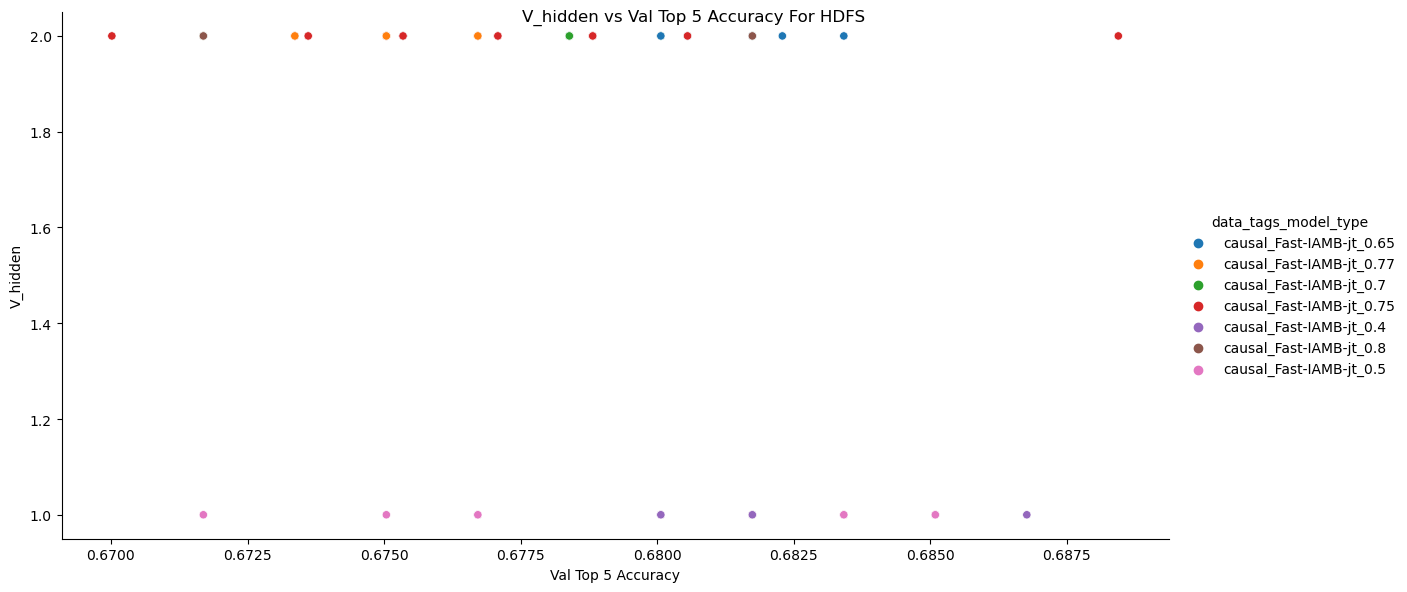

In [126]:
causal_hdfs = hdfs_final_df[hdfs_final_df['data_tags_model_type'].str.startswith('causal')]
g = sns.relplot(data=causal_hdfs, x='val_top_5_categorical_accuracy_history_best', y='V_hidden', hue='data_tags_model_type', height=6, aspect=2)
g.fig.suptitle('V_hidden vs Val Top 5 Accuracy For HDFS')
g.set_xlabels('Val Top 5 Accuracy')
g

#### Compare on basis of drain settings

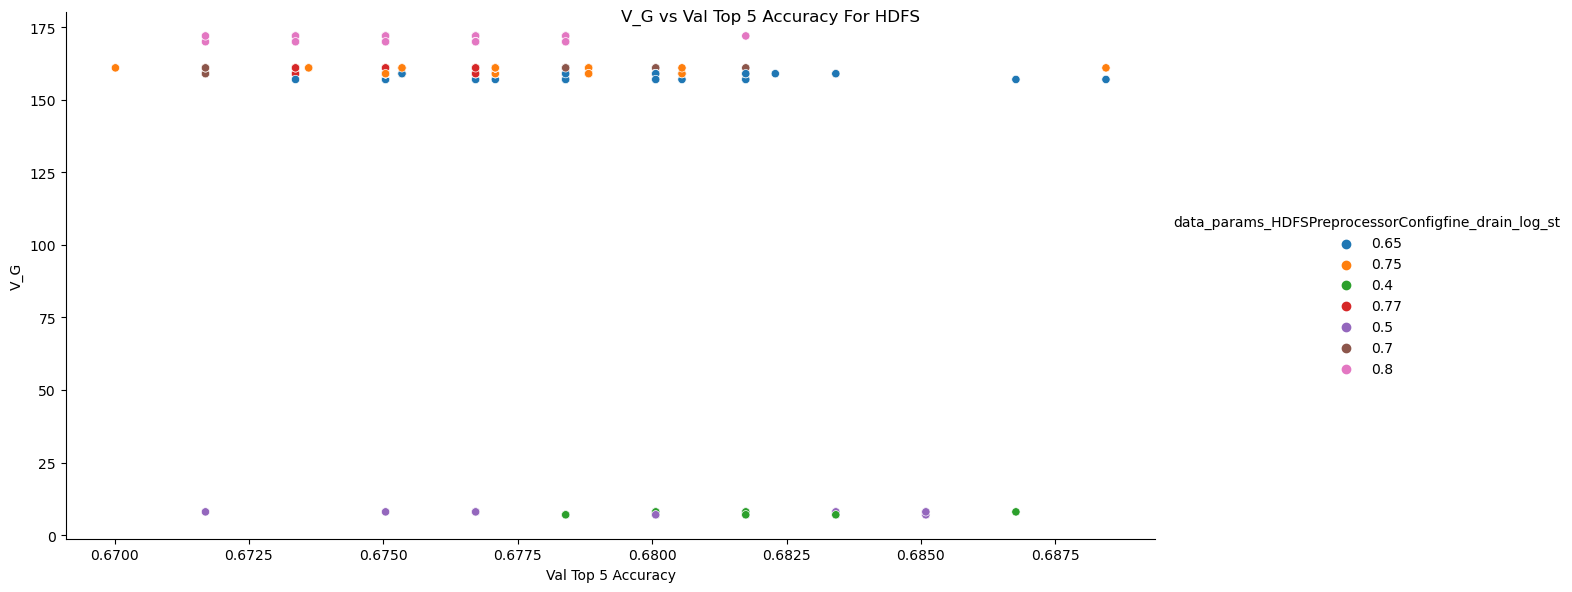

In [117]:
g = sns.relplot(data=hdfs_final_df, x='val_top_5_categorical_accuracy_history_best', y='V_G', hue='data_params_HDFSPreprocessorConfigfine_drain_log_st', height=6, aspect=2)
g.fig.suptitle('V_G vs Val Top 5 Accuracy For HDFS')
g.set_xlabels('Val Top 5 Accuracy')
g

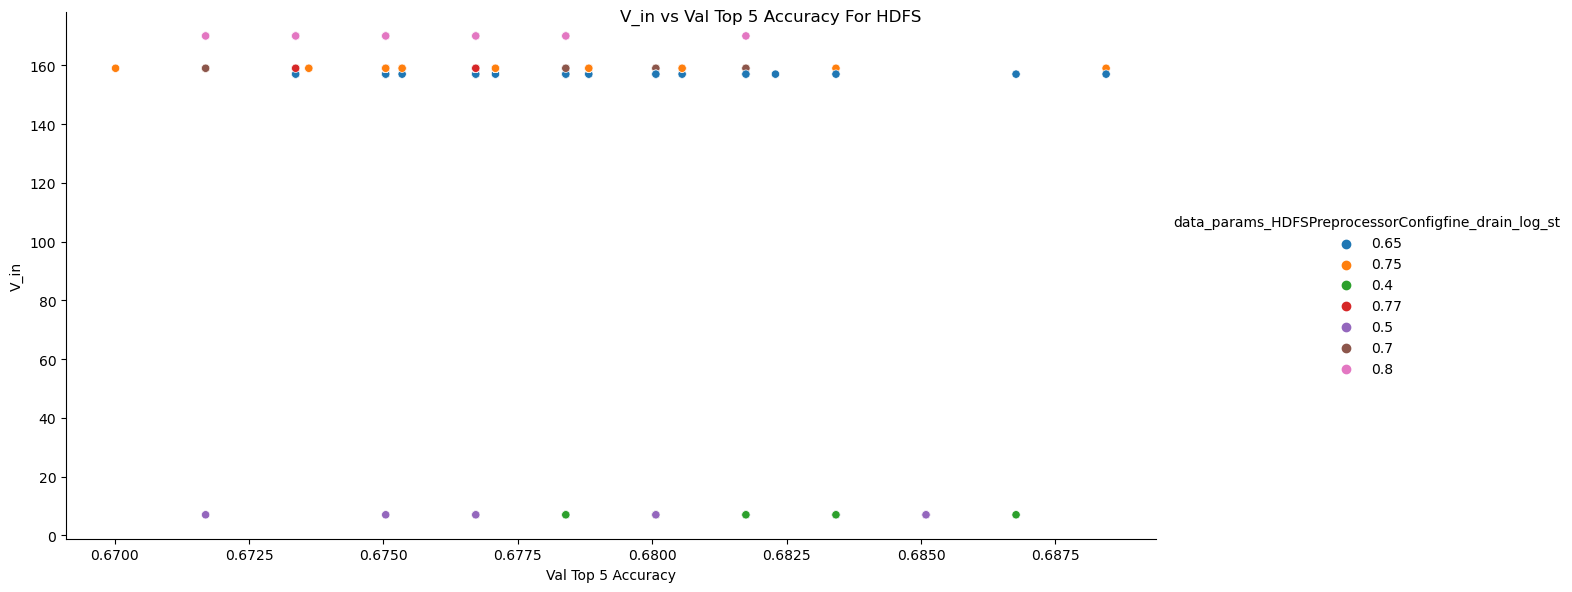

In [125]:
g = sns.relplot(data=hdfs_final_df, x='val_top_5_categorical_accuracy_history_best', y='V_in', hue='data_params_HDFSPreprocessorConfigfine_drain_log_st', height=6, aspect=2)
g.fig.suptitle('V_in vs Val Top 5 Accuracy For HDFS')
g.set_xlabels('Val Top 5 Accuracy')
g

# Results - Performance

## Huawei

In [6]:
experimented_algos = ["causal_Fast-IAMB-jt", "causal_Fast-IAMB-smc-cor", "causal_MMPC-cor"]
huawei_df = mlflow_helper.run_df[
    (mlflow_helper.run_df['data_tags_sequence_type'] == 'huawei_logs')
    & (mlflow_helper.run_df['data_params_ExperimentConfigmax_data_size'] == '-1')
    & (mlflow_helper.run_df['data_tags_model_type'].isin(experimented_algos + ['simple']))
    & (mlflow_helper.run_df['data_params_HuaweiPreprocessorConfigaggregated_log_file'] == 'data/logs_aggregated_concurrent_original.csv')
    & (mlflow_helper.run_df["data_params_SequenceConfigtest_percentage"].fillna("").astype(str) == "0.1")
    & (mlflow_helper.run_df["data_params_ModelConfigbest_model_metric"] == "val_loss")
    & (mlflow_helper.run_df["info_status"] == "FINISHED")
    & (mlflow_helper.run_df["data_params_ModelConfigrnn_dim"] == "200")
    & (mlflow_helper.run_df["data_params_ModelConfigoptimizer"].fillna("adam") == "adam")
    & (mlflow_helper.run_df["data_params_ModelConfigdropout_rate"].fillna("0.0").astype(str) == "0.5")
    & (mlflow_helper.run_df["data_params_ModelConfigrnn_dropout"].fillna("0.0").astype(str) == "0.0")
    & (mlflow_helper.run_df["data_params_ModelConfigkernel_regularizer_scope"].fillna("[]") == "[]")
    & (mlflow_helper.run_df["data_params_ExperimentConfigbatch_size"].astype(str).fillna("") == "128")
    & (mlflow_helper.run_df['data_params_HuaweiPreprocessorConfigaggregated_log_file'] == 'data/logs_aggregated_concurrent_original.csv')
    & (mlflow_helper.run_df['data_params_ExperimentConfigmax_data_size'] == '-1')
    & (mlflow_helper.run_df['data_params_HuaweiPreprocessorConfigcausal_algorithm_alpha'].isin([np.nan, '0.05']))
    & (mlflow_helper.run_df["data_params_HuaweiPreprocessorConfigfine_drain_log_st"].astype(str).fillna("").isin(['0.77', '0.75']))
    & (mlflow_helper.run_df["data_params_HuaweiPreprocessorConfigfine_drain_log_depth"].astype(str).fillna("") == "10")
    & (mlflow_helper.run_df['data_params_ExperimentConfigonly_generate_knowledge'] == 'False')
]
huawei_df = mlflow_helper.load_best_metrics_for_ids(set(huawei_df["info_run_id"]))
huawei_df = categorize_run_df(huawei_df)

Querying metrics for runs: 100%|██████████| 505/505 [00:34<00:00, 14.73it/s]


In [7]:
count_attributes(huawei_df)

data_tags_model_type
causal_Fast-IAMB-jt+small-small_more_templates_without_ts    36
causal_Fast-IAMB-jt+large-medium_without_ts                  22
causal_Fast-IAMB-jt+small-medium_with_ts                     20
simple_with_ts                                               20
simple_more_templates_without_ts                             20
causal_MMPC-cor+large-small_without_ts                       20
causal_Fast-IAMB-smc-cor+small-small_with_ts                 20
causal_Fast-IAMB-jt+small-small_without_ts                   20
causal_Fast-IAMB-jt+large-medium_with_ts                     20
simple_without_ts                                            20
causal_Fast-IAMB-jt+medium-medium_with_ts                    20
causal_Fast-IAMB-smc-cor+small-small_without_ts              19
causal_Fast-IAMB-jt+medium-large_with_ts                     19
causal_Fast-IAMB-jt+large-small_with_ts                      18
causal_Fast-IAMB-jt+small-large_with_ts                      18
causal_Fast-IAMB-jt

In [8]:
pd.options.display.max_colwidth = 100
sorted_top_5_accuracy_median_df = pd.DataFrame(
    huawei_df.groupby(['data_tags_model_type'])['val_top_5_categorical_accuracy_history_best']
    .median()
    .sort_values(ascending=False)).reset_index()
sorted_top_5_accuracy_median_df

,data_tags_model_type,val_top_5_categorical_accuracy_history_best
0,causal_Fast-IAMB-jt+small-small_without_ts,0.833957
1,causal_Fast-IAMB-smc-cor+small-small_without_ts,0.833628
2,causal_Fast-IAMB-jt+small-none_without_ts,0.833443
3,causal_Fast-IAMB-smc-cor+medium-large_without_ts,0.833329
4,causal_Fast-IAMB-jt+large-medium_without_ts,0.833114
5,simple_without_ts,0.832964
6,causal_MMPC-cor+large-medium_without_ts,0.832886
7,causal_MMPC-cor+medium-large_without_ts,0.832772
8,causal_Fast-IAMB-jt+medium-medium_without_ts,0.832757
9,causal_MMPC-cor+medium-medium_without_ts,0.832586


In [9]:
# Sort by mean top 5 categorical accuracy
sorted_top_5_accuracy_mean_df = pd.DataFrame(
    huawei_df.groupby(['data_tags_model_type'])['val_top_5_categorical_accuracy_history_best']
    .mean()
    .sort_values(ascending=False)).reset_index()
sorted_top_5_accuracy_mean_df

,data_tags_model_type,val_top_5_categorical_accuracy_history_best
0,causal_Fast-IAMB-jt+small-small_without_ts,0.834112
1,causal_Fast-IAMB-smc-cor+small-small_without_ts,0.833637
2,causal_Fast-IAMB-jt+small-none_without_ts,0.833443
3,causal_Fast-IAMB-smc-cor+medium-large_without_ts,0.833210
4,causal_MMPC-cor+medium-large_without_ts,0.832930
5,causal_Fast-IAMB-jt+large-medium_without_ts,0.832924
6,simple_without_ts,0.832727
7,causal_MMPC-cor+large-medium_without_ts,0.832672
8,causal_MMPC-cor+small-large_without_ts,0.832666
9,causal_Fast-IAMB-jt+medium-medium_without_ts,0.832652


In [10]:
k = 3
# Without timestamps
top_k_mean_no_ts = sorted_top_5_accuracy_mean_df['data_tags_model_type'].tolist()[:k]
top_k_median_no_ts = sorted_top_5_accuracy_median_df['data_tags_model_type'].tolist()[:k]

if "simple_without_ts" not in top_k_mean_no_ts:
    top_k_mean_no_ts.append('simple_without_ts')

if "simple_without_ts" not in top_k_median_no_ts:
    top_k_median_no_ts.append('simple_without_ts')

# With timestamps
top_k_mean_ts = list(filter(lambda x: x.endswith('with_ts'),sorted_top_5_accuracy_mean_df['data_tags_model_type'].tolist()))[:k]
top_k_median_ts = list(filter(lambda x: x.endswith('with_ts'),sorted_top_5_accuracy_median_df['data_tags_model_type'].tolist()))[:k]

if "simple_with_ts" not in top_k_mean_ts:
    top_k_mean_ts.append('simple_with_ts')

if "simple_with_ts" not in top_k_median_ts:
    top_k_median_ts.append('simple_with_ts')

### With Timestamps

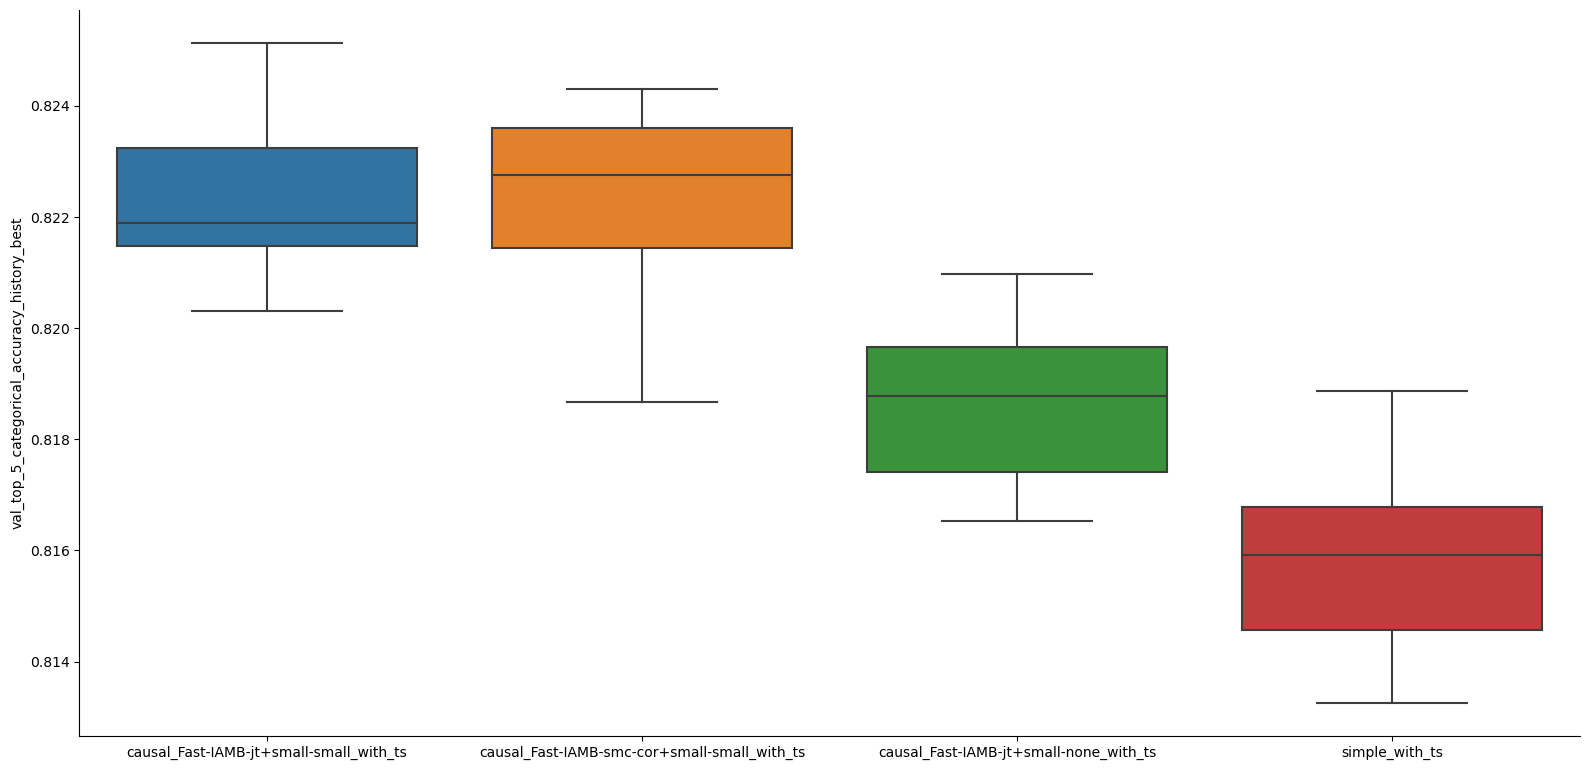

In [11]:
plot_best_metric_bar(huawei_df, ['val_top_5_categorical_accuracy_history_best'],
x_order = top_k_mean_ts,
height=8,
aspect=2)

### Without Timestamps

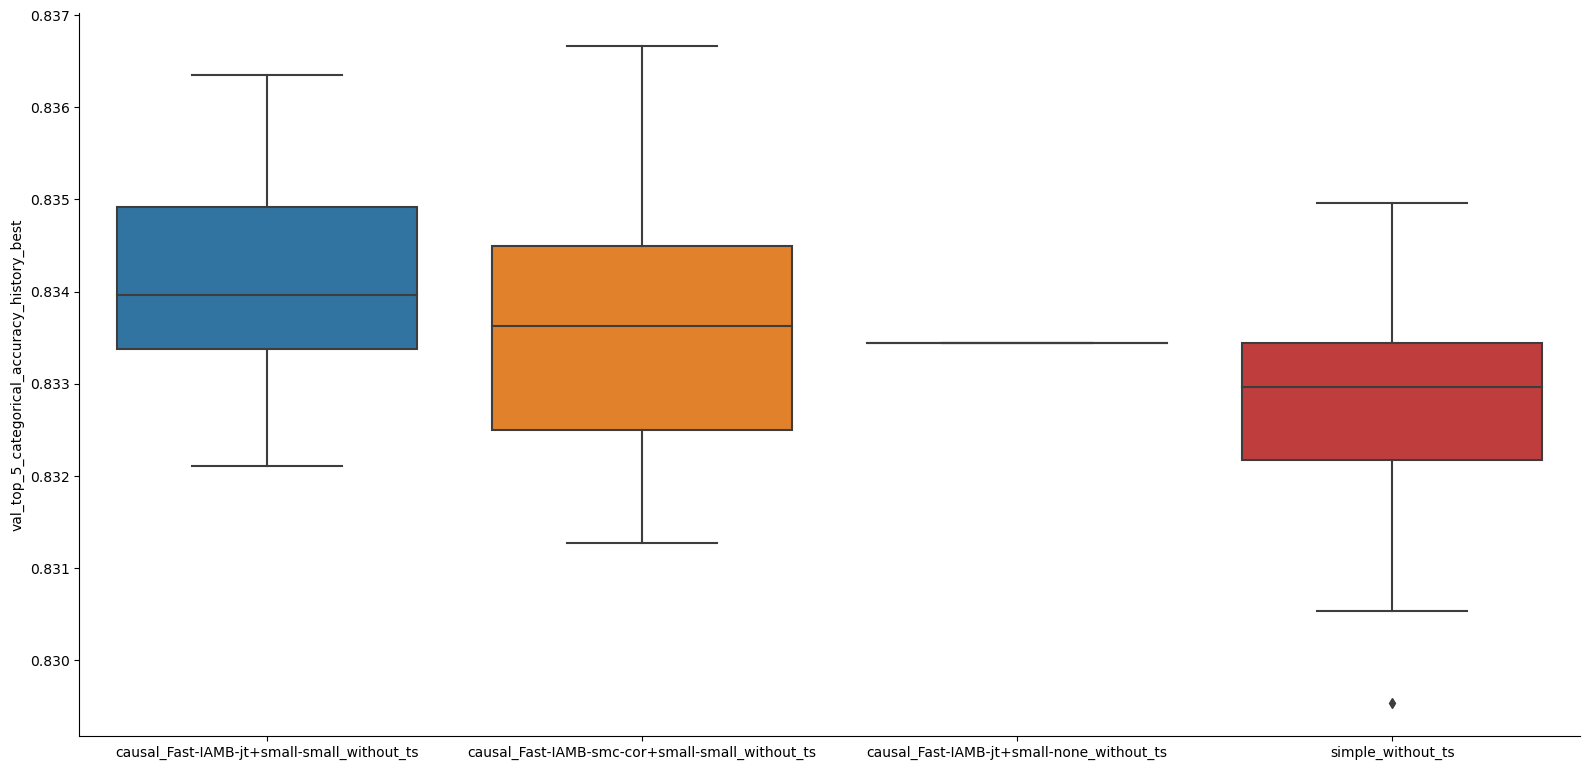

In [12]:
plot_best_metric_bar(huawei_df, ['val_top_5_categorical_accuracy_history_best'],
x_order = top_k_mean_no_ts,
height=8,
aspect=2)

## BGL

In [13]:
bgl_df = mlflow_helper.run_df[
    (mlflow_helper.run_df['data_tags_sequence_type'] == "bgl_logs")
    & (mlflow_helper.run_df['data_params_BGLPreprocessorConfigaggregated_log_file'] == 'data/BGL_2k.csv')
    & (mlflow_helper.run_df['data_params_ExperimentConfigonly_generate_knowledge'] == 'False')
]
# Categorize by templates
bgl_df.loc[bgl_df['data_params_HuaweiPreprocessorConfigfine_drain_log_st'] == '0.77', 'data_tags_model_type'] = bgl_df.loc[
    bgl_df['data_params_HuaweiPreprocessorConfigfine_drain_log_st'] == '0.77', 'data_tags_model_type'
].apply(lambda x: x + "_more_templates")
bgl_df.loc[bgl_df['data_params_HuaweiPreprocessorConfigfine_drain_log_st'] == '0.73', 'data_tags_model_type'] = bgl_df.loc[
    bgl_df['data_params_HuaweiPreprocessorConfigfine_drain_log_st'] == '0.73', 'data_tags_model_type'
].apply(lambda x: x + "_less_templates")
bgl_df = mlflow_helper.load_best_metrics_for_ids(set(bgl_df['info_run_id']))

Querying metrics for runs: 100%|██████████| 100/100 [00:10<00:00,  9.11it/s]


In [14]:
count_attributes(bgl_df)

data_tags_model_type
causal_Fast-IAMB-jt    20
causal_heuristic       20
hierarchy              20
simple                 20
text                   20
Name: data_tags_model_type, dtype: int64

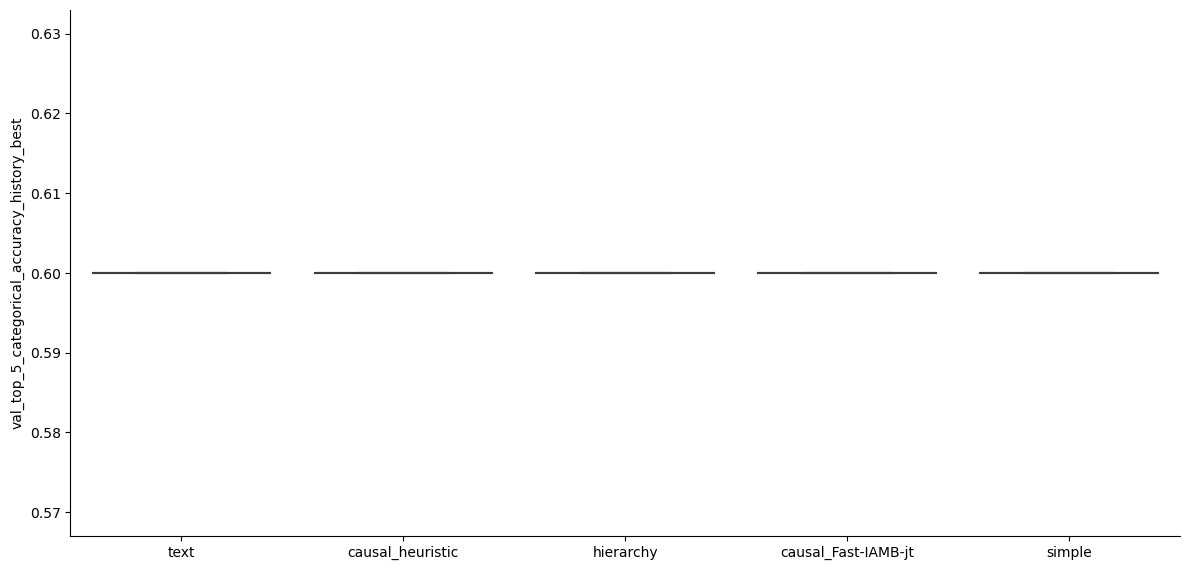

In [15]:
model_types = list(set(bgl_df['data_tags_model_type']))
plot_best_metric_bar(bgl_df, ['val_top_5_categorical_accuracy_history_best'], x_order=model_types, height=6, aspect=2)

## HDFS

In [16]:
hdfs_df = mlflow_helper.run_df[
    (mlflow_helper.run_df['data_tags_sequence_type'] == "hdfs_logs")
    & (mlflow_helper.run_df['data_params_HDFSPreprocessorConfigaggregated_log_file'] == 'data/HDFS_2k.csv')
    & (mlflow_helper.run_df['data_params_ExperimentConfigonly_generate_knowledge'] == 'False')
]
hdfs_df = mlflow_helper.load_best_metrics_for_ids(set(hdfs_df['info_run_id']))
# Categorize by templates
hdfs_df.loc[hdfs_df['data_params_HuaweiPreprocessorConfigfine_drain_log_st'] == '0.77', 'data_tags_model_type'] = hdfs_df.loc[
    hdfs_df['data_params_HuaweiPreprocessorConfigfine_drain_log_st'] == '0.77', 'data_tags_model_type'
].apply(lambda x: x + "_more_templates")
hdfs_df.loc[hdfs_df['data_params_HuaweiPreprocessorConfigfine_drain_log_st'] == '0.73', 'data_tags_model_type'] = hdfs_df.loc[
    hdfs_df['data_params_HuaweiPreprocessorConfigfine_drain_log_st'] == '0.73', 'data_tags_model_type'
].apply(lambda x: x + "_less_templates")

Querying metrics for runs: 100%|██████████| 136/136 [00:14<00:00,  9.24it/s]


In [17]:
count_attributes(hdfs_df)

data_tags_model_type
causal_heuristic       44
text                   32
causal_Fast-IAMB-jt    20
hierarchy              20
simple                 20
Name: data_tags_model_type, dtype: int64

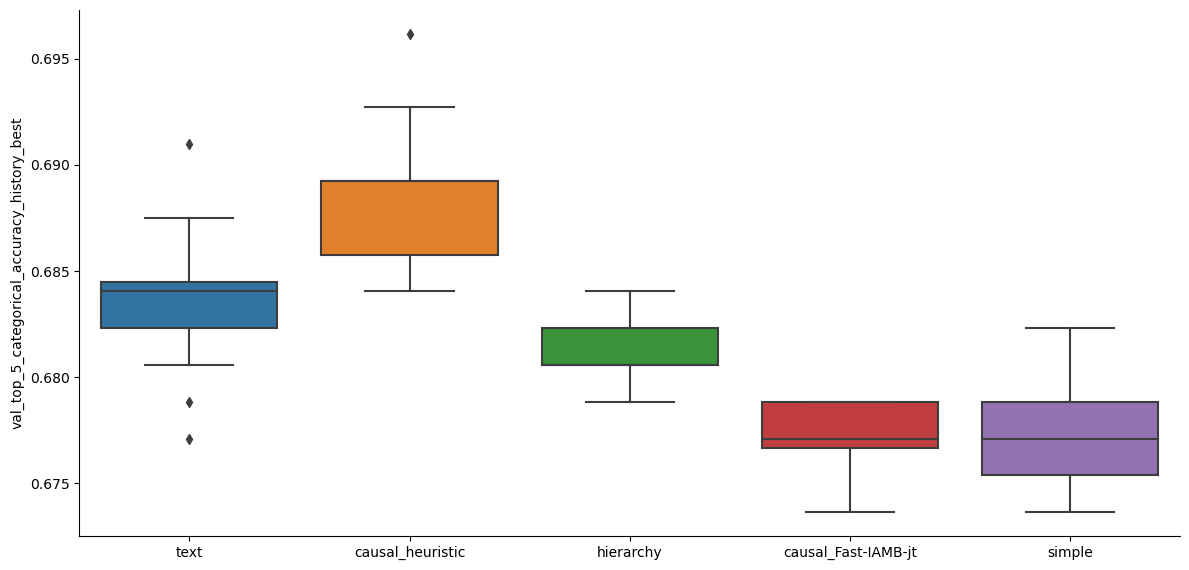

In [18]:
model_types = list(set(hdfs_df['data_tags_model_type']))
plot_best_metric_bar(hdfs_df, ['val_top_5_categorical_accuracy_history_best'], x_order=model_types, height=6, aspect=2)

# Results - Scatter Plots

In [19]:
def read_knowledge_dataframes(knowledge_type):
    knowledge_path = Path(f'/home/i40/almasrirz/Domain-Guided-Monitoring/data/knowledge_{knowledge_type}')
    pathlist = knowledge_path.glob('**/*.csv')
    dataframes = {}
    for path in pathlist:
        knowledge_name = path.name.split('_knowledge')[0]
        dataframes[knowledge_name] = pd.read_csv(path)
    return dataframes

In [20]:
def fetch_statistics(knowledge_type):
    statistics_records = []
    dataframes = read_knowledge_dataframes(knowledge_type)
    for name, df in dataframes.items():
        k = None
        metadata = f'/home/i40/almasrirz/Domain-Guided-Monitoring/data/knowledge_{knowledge_type}/x_vocab'
        if 'with_ts' in name:
            metadata += '_with_ts'
        if 'without_ts' in name:
            metadata += '_without_ts'
        if 'more_templates' in name:
            metadata += '_more_templates'
           
        with open(metadata + '.json', 'r') as file:
            metadata = json.load(file)

        if name.startswith('causal'):
            k = knowledge.CausalityKnowledge(knowledge.KnowledgeConfig())
            k.build_causality_from_df(df, metadata)
        elif name.startswith('hierarchy'):
            k = knowledge.HierarchyKnowledge(knowledge.KnowledgeConfig())
            k.build_hierarchy_from_df(df, metadata)
        else:
            k = knowledge.DescriptionKnowledge(knowledge.KnowledgeConfig())
            k.build_knowledge_from_df(df, metadata)
        v_in = len(k.vocab)
        v_g = len(k.extended_vocab)
        v_hidden = v_g - v_in
        edges = set()
        for i in range(len(k.vocab)):
            connections = k.get_connections_for_idx(i)
            for connection in connections:
                edges.add((i, connection))
        statistics_records.append({
            'Model': name,
            'V_G': v_g,
            'V_in': v_in,
            'V_hidden': v_hidden,
            'E_G': len(edges)
        })
    return pd.DataFrame.from_records(statistics_records)

## BGL

In [21]:
bgl_stats_df = fetch_statistics('bgl')
bgl_stats_df = bgl_stats_df[~(bgl_stats_df['Model'].str.endswith('label'))]
bgl_stats_df

Building Hierarchy from df: 19705it [00:00, 41538.30it/s]
Building Causality from df: 55564it [00:01, 42168.32it/s]
Building Causality from df: 8238it [00:00, 44122.77it/s]
Preprocessing description words: 100%|██████████| 4728/4728 [00:00<00:00, 41795.94it/s]
Building Causality from df: 28021it [00:00, 40489.68it/s]
Building Causality from df: 750it [00:00, 44013.43it/s]
Building Hierarchy from df: 7153it [00:00, 38873.54it/s]
Building Causality from df: 82it [00:00, 41542.81it/s]
Preprocessing description words: 100%|██████████| 2007/2007 [00:00<00:00, 41364.31it/s]


,Model,V_G,V_in,V_hidden,E_G
4,causal_heuristic,2007,1,2006,2007
6,hierarchy,5150,1,5149,5150
7,causal_Fast-IAMB-jt,2,1,1,2
8,text,4,1,3,4


In [22]:
bgl_sp_df = pd.merge(bgl_df, bgl_stats_df, how='left', left_on='data_tags_model_type', right_on='Model')
set(bgl_sp_df['data_tags_model_type'])

{'causal_Fast-IAMB-jt', 'causal_heuristic', 'hierarchy', 'simple', 'text'}

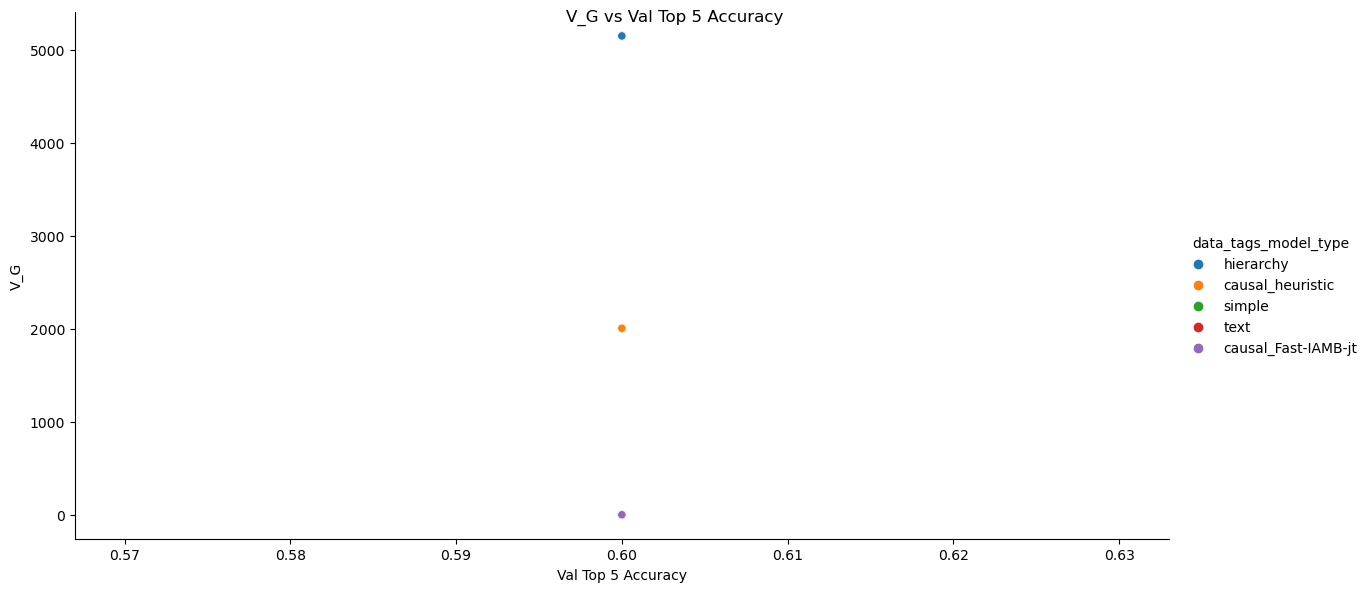

In [23]:
g = sns.relplot(data=bgl_sp_df, x='val_top_5_categorical_accuracy_history_best', y='V_G', hue='data_tags_model_type', height=6, aspect=2)
g.fig.suptitle('V_G vs Val Top 5 Accuracy')
g.set_xlabels('Val Top 5 Accuracy')
g

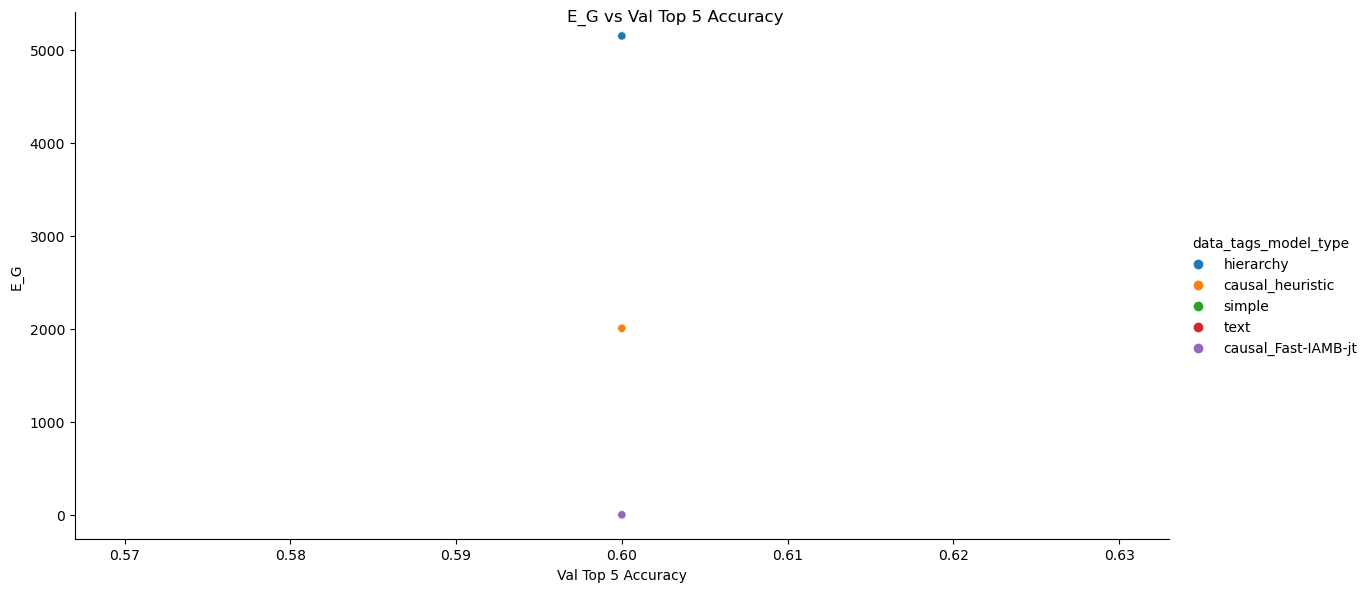

In [24]:
g = sns.relplot(data=bgl_sp_df, x='val_top_5_categorical_accuracy_history_best', y='E_G', hue='data_tags_model_type', height=6, aspect=2)
g.fig.suptitle('E_G vs Val Top 5 Accuracy')
g.set_xlabels('Val Top 5 Accuracy')
g

## HDFS

In [25]:
hdfs_stats_df = fetch_statistics('hdfs')
hdfs_stats_df

Building Causality from df: 9524it [00:00, 38484.93it/s]
Building Causality from df: 9524it [00:00, 39051.80it/s]
Building Causality from df: 9551it [00:00, 39431.85it/s]
Preprocessing description words: 100%|██████████| 677/677 [00:00<00:00, 37327.06it/s]
Building Hierarchy from df: 2050it [00:00, 38786.92it/s]
Building Causality from df: 36it [00:00, 38120.41it/s]
Preprocessing description words: 100%|██████████| 673/673 [00:00<00:00, 36864.21it/s]


,Model,V_G,V_in,V_hidden,E_G
0,causal_heuristic_less_templates,673,166,507,3073
1,causal_heuristic,673,166,507,3073
2,causal_heuristic_more_templates,677,170,507,3103
3,text_more_templates,516,170,346,886
4,hierarchy,675,166,509,2704
5,causal_Fast-IAMB-jt,170,166,4,172
6,text,507,166,341,864
7,text_less_templates,507,166,341,864


In [26]:
hdfs_sp_df = pd.merge(hdfs_df, hdfs_stats_df, how='left', left_on='data_tags_model_type', right_on='Model')
set(hdfs_sp_df['data_tags_model_type'])

{'causal_Fast-IAMB-jt', 'causal_heuristic', 'hierarchy', 'simple', 'text'}

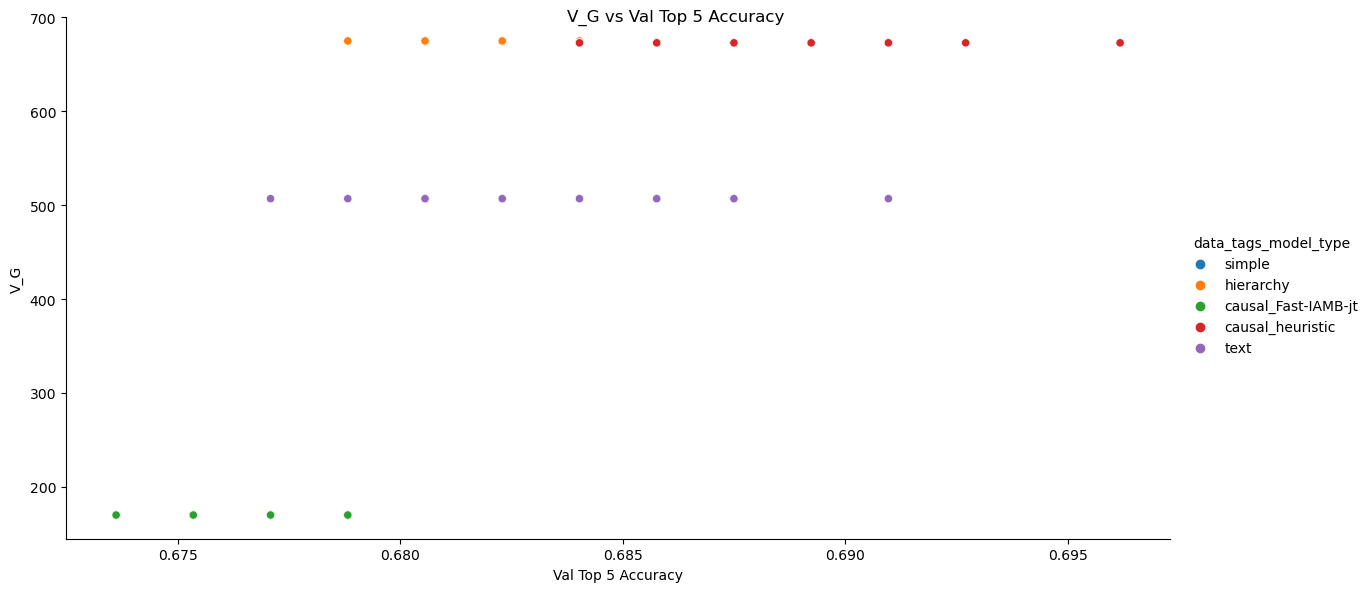

In [27]:
g = sns.relplot(data=hdfs_sp_df, x='val_top_5_categorical_accuracy_history_best', y='V_G', hue='data_tags_model_type', height=6, aspect=2)
g.fig.suptitle('V_G vs Val Top 5 Accuracy')
g.set_xlabels('Val Top 5 Accuracy')
g

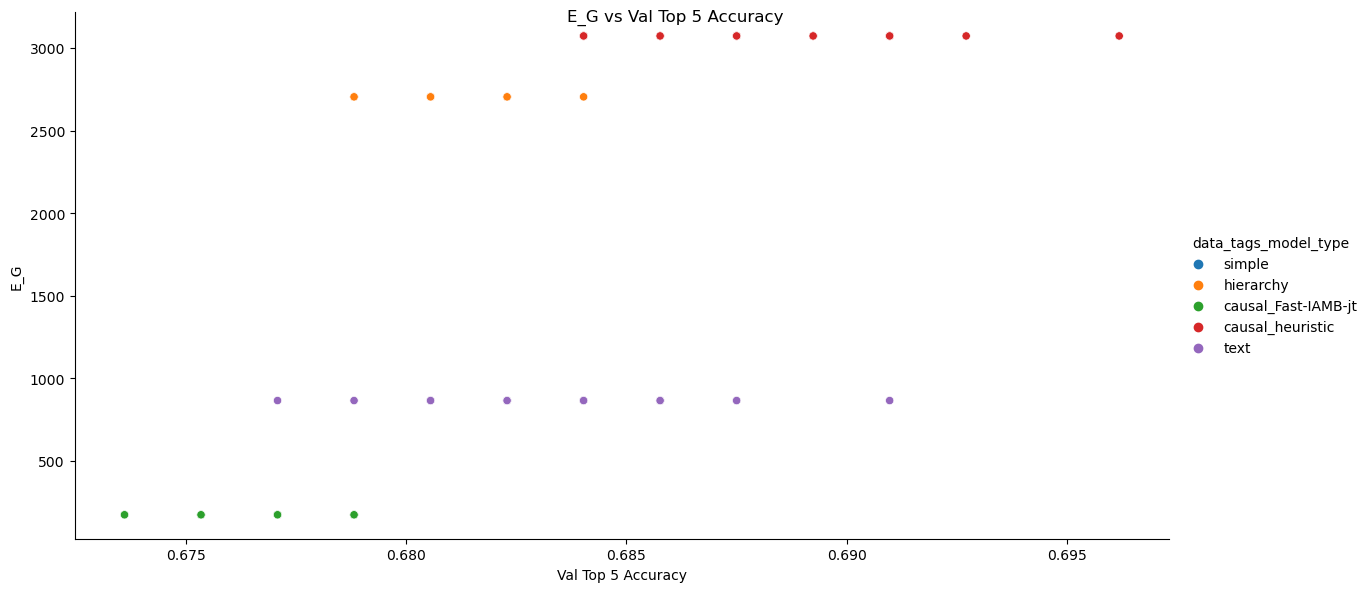

In [28]:
g = sns.relplot(data=hdfs_sp_df, x='val_top_5_categorical_accuracy_history_best', y='E_G', hue='data_tags_model_type', height=6, aspect=2)
g.fig.suptitle('E_G vs Val Top 5 Accuracy')
g.set_xlabels('Val Top 5 Accuracy')
g

## Huawei

In [29]:
knowledge_types_with_ts = ['simple_with_ts',
                           'causal_heuristic_with_ts',
                           'text_with_ts',
                           'hierarchy_with_ts',
                           'causal_Fast-IAMB-jt_with_ts_small_small',
                           'causal_Fast-IAMB-jt_with_ts_more_templates_small_small']
knowledge_types_without_ts = ['simple_without_ts',
                           'causal_heuristic_without_ts',
                           'text_without_ts',
                           'text_without_ts_more_templates',
                           'hierarchy_without_ts',
                           'hierarchy_without_ts_more_templates',
                           'causal_Fast-IAMB-jt_without_ts_small_small',
                           'causal_Fast-IAMB-jt_without_ts_more_templates_small_small']

In [30]:
experimented_algos = ["causal_Fast-IAMB-jt", "simple", "hierarchy", "text", "causal_heuristic"]
huawei_df = mlflow_helper.run_df[
    (mlflow_helper.run_df['data_tags_sequence_type'] == 'huawei_logs')
    & (mlflow_helper.run_df['data_params_ExperimentConfigmax_data_size'] == '-1')
    & (mlflow_helper.run_df['data_tags_model_type'].isin(experimented_algos))
    & (mlflow_helper.run_df["info_status"] == "FINISHED")
    & (mlflow_helper.run_df['data_params_ExperimentConfigmax_data_size'] == '-1')
    & (mlflow_helper.run_df['data_params_HuaweiPreprocessorConfigaggregated_log_file'] == 'data/logs_aggregated_concurrent_original.csv')
    & (mlflow_helper.run_df['data_params_HuaweiPreprocessorConfigmin_causality'] == '0.01')
    & (mlflow_helper.run_df['data_params_HuaweiPreprocessorConfigcausal_algorithm_alpha'].isin([np.nan, '0.05']))
    & (mlflow_helper.run_df["data_params_HuaweiPreprocessorConfigfine_drain_log_st"].astype(str).fillna("").isin(['0.77', '0.75']))
    & (mlflow_helper.run_df["data_params_HuaweiPreprocessorConfigfine_drain_log_depth"].astype(str).fillna("") == "10")
    & (mlflow_helper.run_df['data_params_ExperimentConfigonly_generate_knowledge'] == 'False')
]
huawei_df = mlflow_helper.load_best_metrics_for_ids(set(huawei_df["info_run_id"]))
huawei_df = categorize_run_df(huawei_df)

Querying metrics for runs: 100%|██████████| 451/451 [00:40<00:00, 11.21it/s]


In [ ]:
huawei_stats_df = fetch_statistics('huawei')

In [32]:
huawei_stats_with_ts_df = huawei_stats_df[huawei_stats_df['Model'].isin(knowledge_types_with_ts)]
huawei_stats_with_ts_df

,Model,V_G,V_in,V_hidden,E_G
2,causal_Fast-IAMB-jt_with_ts_more_templates_small_small,4105,3905,200,5646
7,hierarchy_with_ts,1968,1446,522,24817
35,causal_heuristic_with_ts,2104,1446,658,35835
58,causal_Fast-IAMB-jt_with_ts_small_small,1653,1446,207,2166


In [33]:
huawei_stats_without_ts_df = huawei_stats_df[huawei_stats_df['Model'].isin(knowledge_types_without_ts)]
huawei_stats_without_ts_df

,Model,V_G,V_in,V_hidden,E_G
9,text_without_ts_more_templates,7260,3062,4198,30157
14,causal_heuristic_without_ts,1559,865,694,19591
21,causal_Fast-IAMB-jt_without_ts_small_small,1091,865,226,1132
22,text_without_ts,3716,865,2851,17778
34,hierarchy_without_ts,1387,865,522,15335
42,hierarchy_without_ts_more_templates,3580,3062,518,51434
51,causal_Fast-IAMB-jt_without_ts_more_templates_small_small,3288,3062,226,4531


In [34]:
huawei_stats_filtered_df = pd.concat([huawei_stats_with_ts_df, huawei_stats_without_ts_df]).reset_index(drop=True)
huawei_stats_filtered_df

,Model,V_G,V_in,V_hidden,E_G
0,causal_Fast-IAMB-jt_with_ts_more_templates_small_small,4105,3905,200,5646
1,hierarchy_with_ts,1968,1446,522,24817
2,causal_heuristic_with_ts,2104,1446,658,35835
3,causal_Fast-IAMB-jt_with_ts_small_small,1653,1446,207,2166
4,text_without_ts_more_templates,7260,3062,4198,30157
5,causal_heuristic_without_ts,1559,865,694,19591
6,causal_Fast-IAMB-jt_without_ts_small_small,1091,865,226,1132
7,text_without_ts,3716,865,2851,17778
8,hierarchy_without_ts,1387,865,522,15335
9,hierarchy_without_ts_more_templates,3580,3062,518,51434


In [35]:
# Need to replace the causal_Fast-IAMB-jt column name to match the huawei_df
huawei_stats_filtered_df.replace({
    'causal_Fast-IAMB-jt_with_ts_more_templates_small_small': 'causal_Fast-IAMB-jt+small-small_more_templates_with_ts',
    'causal_Fast-IAMB-jt_without_ts_more_templates_small_small': 'causal_Fast-IAMB-jt+small-small_more_templates_without_ts',
    'causal_Fast-IAMB-jt_with_ts_small_small': 'causal_Fast-IAMB-jt+small_small_with_ts',
    'causal_Fast-IAMB-jt_without_ts_small_small': 'causal_Fast-IAMB-jt+small-small_without_ts',
    'causal_Fast-IAMB-jt_with_ts_small_small': 'causal_Fast-IAMB-jt+small-small_with_ts',
    'hierarchy_without_ts_more_templates': 'hierarchy_more_templates_without_ts',
    'text_without_ts_more_templates': 'text_more_templates_without_ts',
    }, inplace=True)
huawei_stats_filtered_df

,Model,V_G,V_in,V_hidden,E_G
0,causal_Fast-IAMB-jt+small-small_more_templates_with_ts,4105,3905,200,5646
1,hierarchy_with_ts,1968,1446,522,24817
2,causal_heuristic_with_ts,2104,1446,658,35835
3,causal_Fast-IAMB-jt+small-small_with_ts,1653,1446,207,2166
4,text_more_templates_without_ts,7260,3062,4198,30157
5,causal_heuristic_without_ts,1559,865,694,19591
6,causal_Fast-IAMB-jt+small-small_without_ts,1091,865,226,1132
7,text_without_ts,3716,865,2851,17778
8,hierarchy_without_ts,1387,865,522,15335
9,hierarchy_more_templates_without_ts,3580,3062,518,51434


In [36]:
count_attributes(huawei_df)

data_tags_model_type
causal_Fast-IAMB-jt+small-small_more_templates_without_ts    36
hierarchy_without_ts                                         28
causal_Fast-IAMB-jt+large-medium_without_ts                  22
text_without_ts                                              21
text_more_templates_without_ts                               21
causal_Fast-IAMB-jt+small-small_without_ts                   20
causal_Fast-IAMB-jt+medium-medium_with_ts                    20
simple_more_templates_without_ts                             20
causal_Fast-IAMB-jt+small-medium_with_ts                     20
causal_Fast-IAMB-jt+large-medium_with_ts                     20
causal_heuristic_with_ts                                     20
causal_Fast-IAMB-jt+medium-large_with_ts                     19
causal_Fast-IAMB-jt+large-small_with_ts                      18
causal_Fast-IAMB-jt+small-large_with_ts                      18
causal_Fast-IAMB-jt+medium-none_with_ts                      17
causal_Fast-IAMB-jt

In [37]:
huawei_filtered_df = huawei_df[huawei_df['data_tags_model_type'].isin(huawei_stats_filtered_df['Model'].tolist())]
count_attributes(huawei_filtered_df)

data_tags_model_type
causal_Fast-IAMB-jt+small-small_more_templates_without_ts    36
hierarchy_without_ts                                         28
text_more_templates_without_ts                               21
text_without_ts                                              21
causal_Fast-IAMB-jt+small-small_without_ts                   20
causal_heuristic_with_ts                                     20
causal_Fast-IAMB-jt+small-small_with_ts                      15
hierarchy_more_templates_without_ts                          14
hierarchy_with_ts                                             9
causal_heuristic_without_ts                                   4
causal_Fast-IAMB-jt+small-small_more_templates_with_ts        3
Name: data_tags_model_type, dtype: int64

In [38]:
huawei_merged_df = pd.merge(huawei_filtered_df, huawei_stats_filtered_df, how='left', left_on=['data_tags_model_type'], right_on=['Model'])

In [39]:
count_attributes(huawei_filtered_df)

data_tags_model_type
causal_Fast-IAMB-jt+small-small_more_templates_without_ts    36
hierarchy_without_ts                                         28
text_more_templates_without_ts                               21
text_without_ts                                              21
causal_Fast-IAMB-jt+small-small_without_ts                   20
causal_heuristic_with_ts                                     20
causal_Fast-IAMB-jt+small-small_with_ts                      15
hierarchy_more_templates_without_ts                          14
hierarchy_with_ts                                             9
causal_heuristic_without_ts                                   4
causal_Fast-IAMB-jt+small-small_more_templates_with_ts        3
Name: data_tags_model_type, dtype: int64

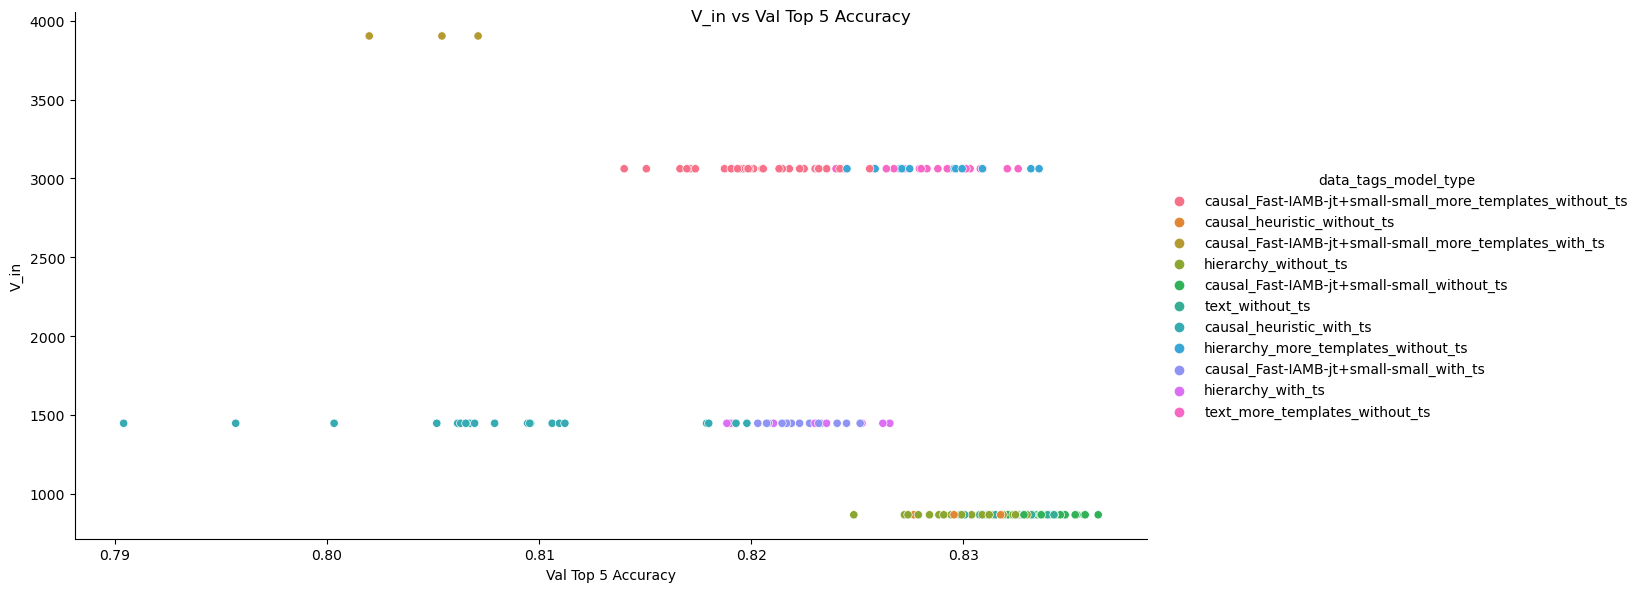

In [40]:
g = sns.relplot(data=huawei_merged_df, x='val_top_5_categorical_accuracy_history_best', y='V_in', hue='data_tags_model_type', height=6, aspect=2)
g.fig.suptitle('V_in vs Val Top 5 Accuracy')
g.set_xlabels('Val Top 5 Accuracy')
g

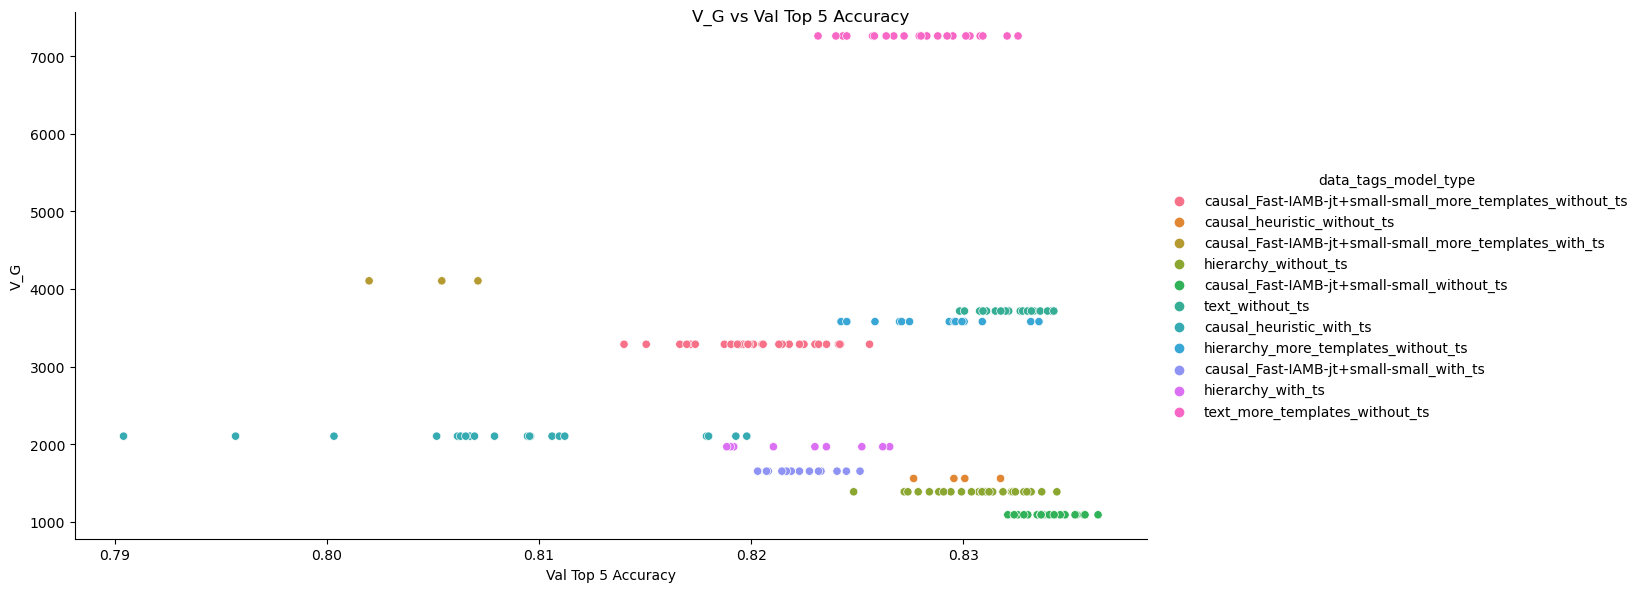

In [41]:
g = sns.relplot(data=huawei_merged_df, x='val_top_5_categorical_accuracy_history_best', y='V_G', hue='data_tags_model_type', height=6, aspect=2)
g.fig.suptitle('V_G vs Val Top 5 Accuracy')
g.set_xlabels('Val Top 5 Accuracy')
g

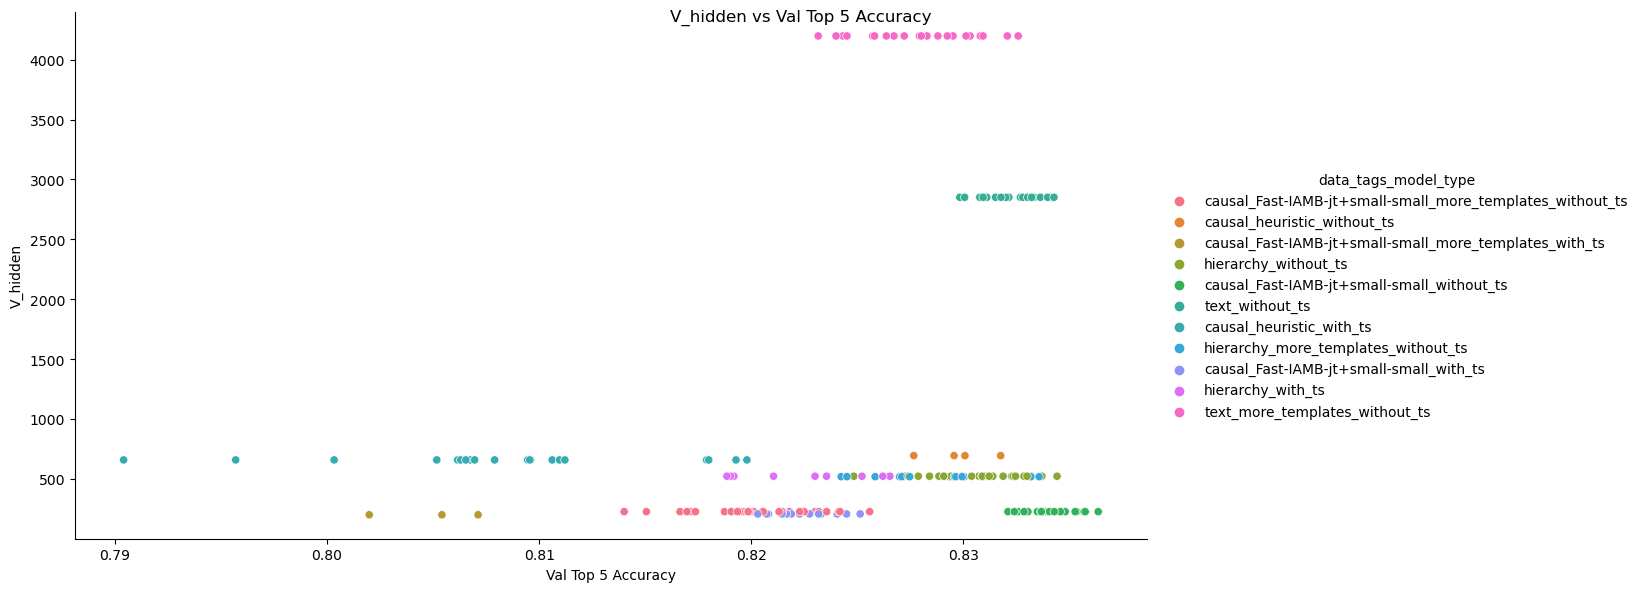

In [42]:
g = sns.relplot(data=huawei_merged_df, x='val_top_5_categorical_accuracy_history_best', y='V_hidden', hue='data_tags_model_type', height=6, aspect=2)
g.fig.suptitle('V_hidden vs Val Top 5 Accuracy')
g.set_xlabels('Val Top 5 Accuracy')
g

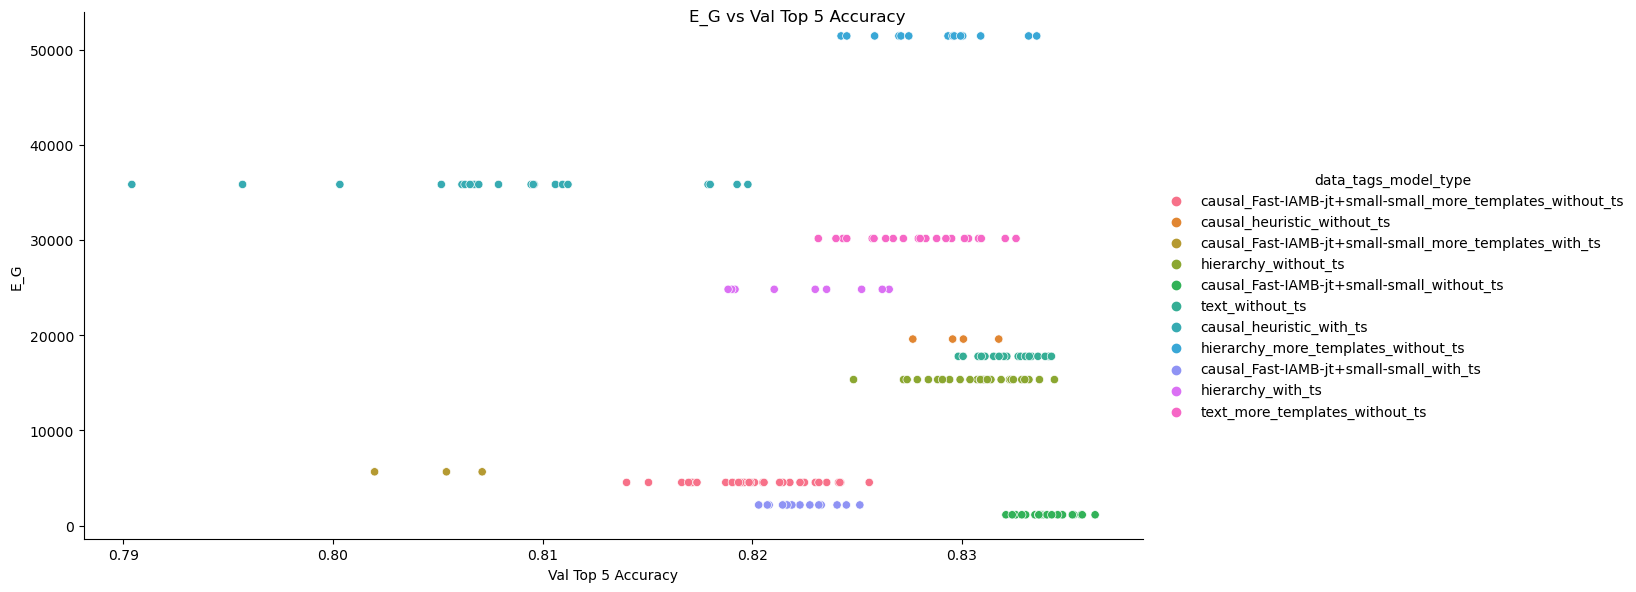

In [43]:
g = sns.relplot(data=huawei_merged_df, x='val_top_5_categorical_accuracy_history_best', y='E_G', hue='data_tags_model_type', height=6, aspect=2)
g.fig.suptitle('E_G vs Val Top 5 Accuracy')
g.set_xlabels('Val Top 5 Accuracy')
g

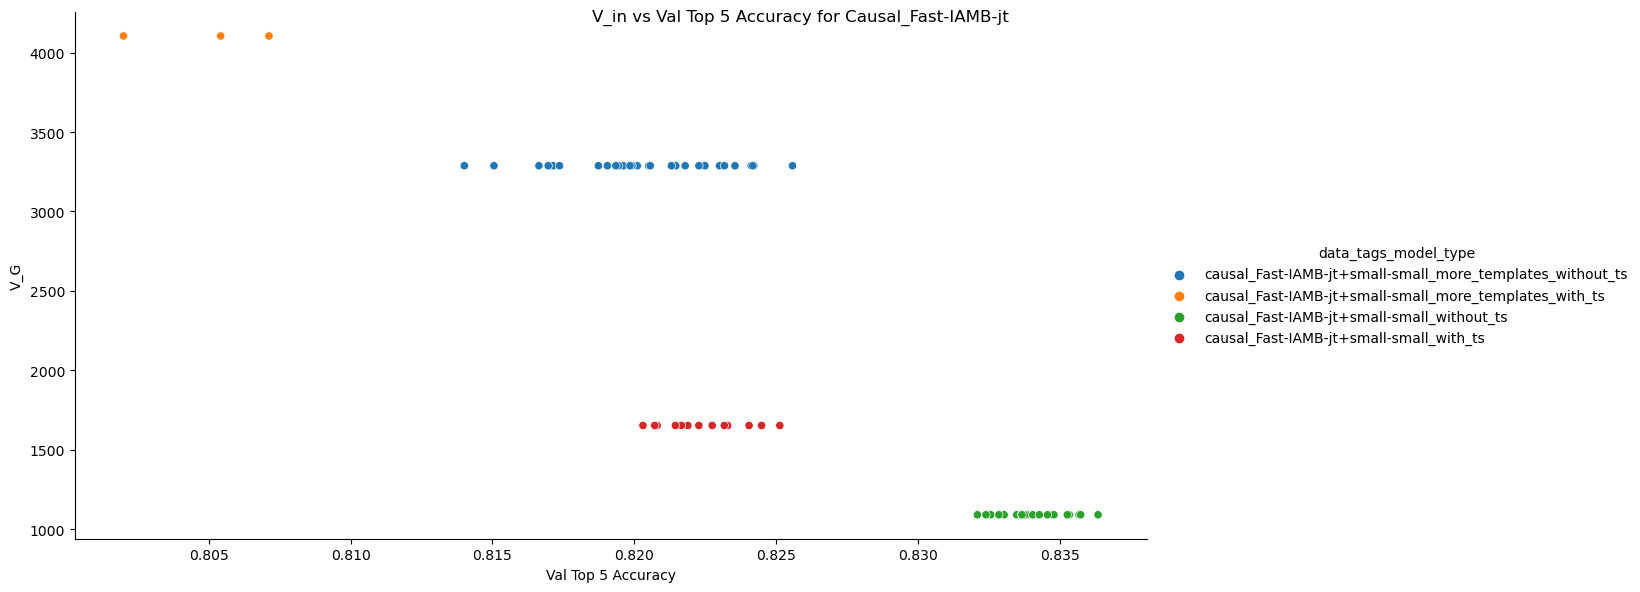

In [44]:
df = huawei_merged_df[huawei_merged_df['data_tags_model_type'].str.startswith('causal_Fast-IAMB-jt')]
g = sns.relplot(data=df, x='val_top_5_categorical_accuracy_history_best', y='V_G', hue='data_tags_model_type', height=6, aspect=2)
g.fig.suptitle('V_in vs Val Top 5 Accuracy for Causal_Fast-IAMB-jt')
g.set_xlabels('Val Top 5 Accuracy')
g

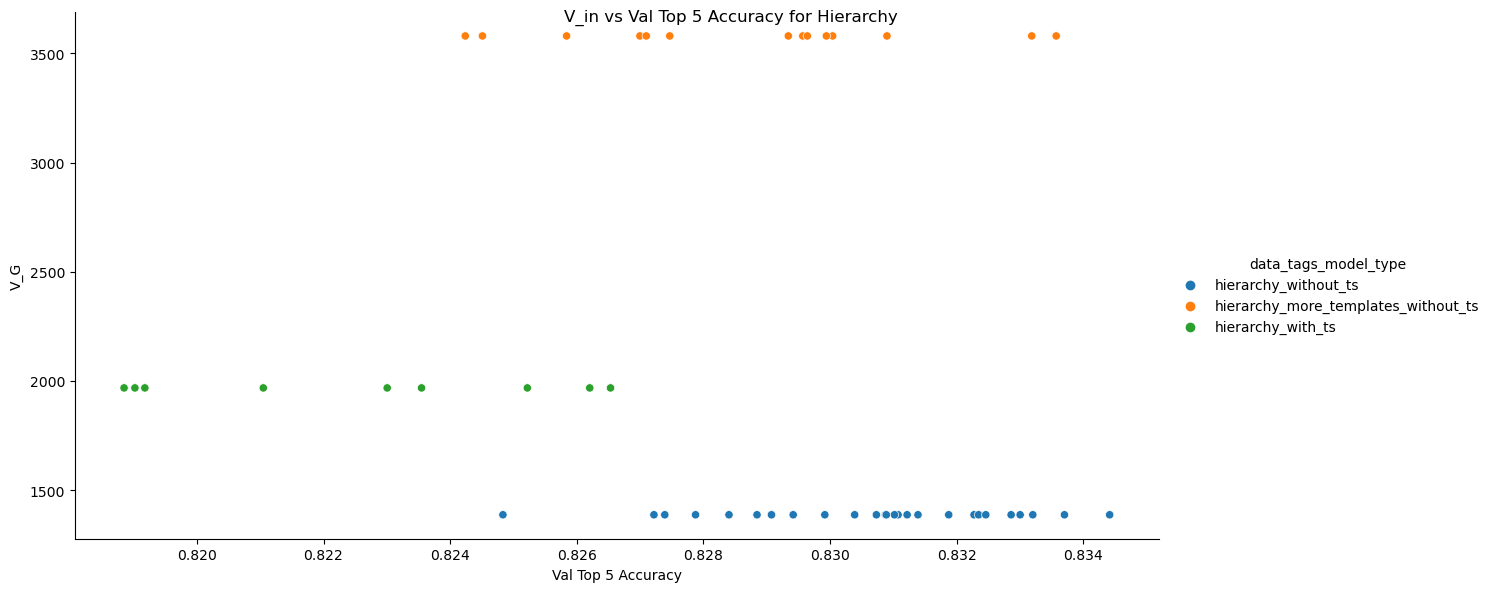

In [45]:
df = huawei_merged_df[huawei_merged_df['data_tags_model_type'].str.startswith('hierarchy')]
g = sns.relplot(data=df, x='val_top_5_categorical_accuracy_history_best', y='V_G', hue='data_tags_model_type', height=6, aspect=2)
g.fig.suptitle('V_in vs Val Top 5 Accuracy for Hierarchy')
g.set_xlabels('Val Top 5 Accuracy')
g

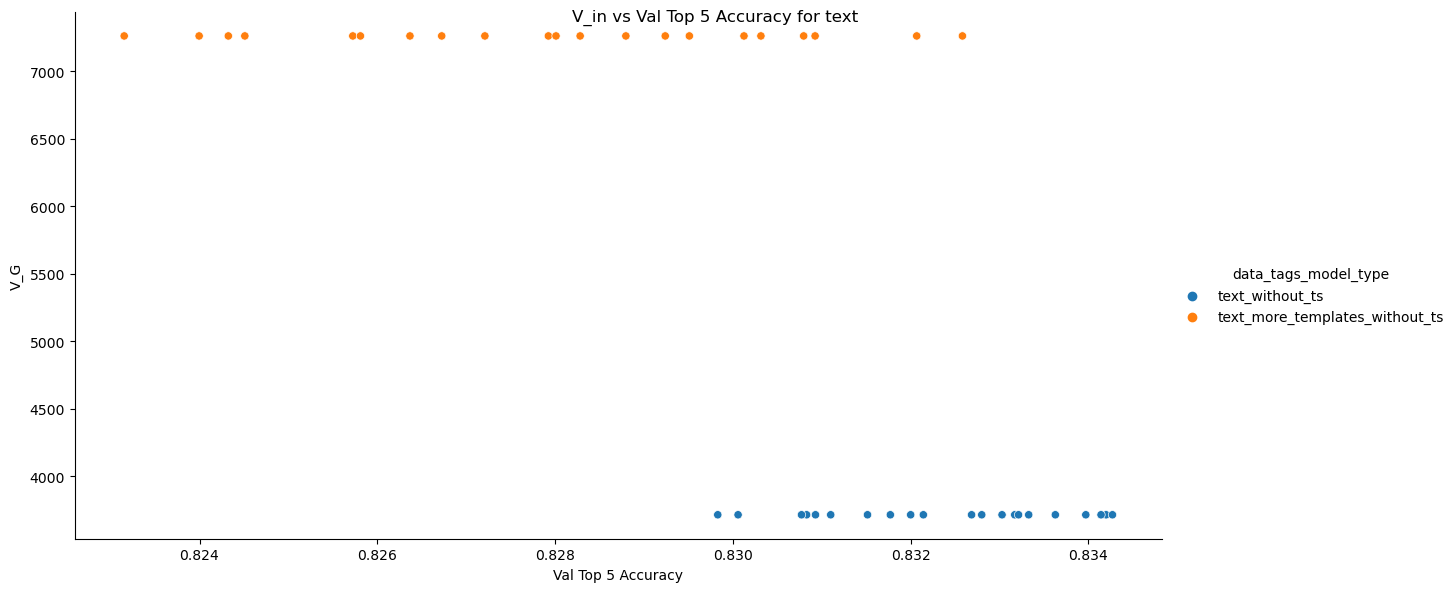

In [46]:
df = huawei_merged_df[huawei_merged_df['data_tags_model_type'].str.startswith('text')]
g = sns.relplot(data=df, x='val_top_5_categorical_accuracy_history_best', y='V_G', hue='data_tags_model_type', height=6, aspect=2)
g.fig.suptitle('V_in vs Val Top 5 Accuracy for text')
g.set_xlabels('Val Top 5 Accuracy')
g